In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import Counter, defaultdict
import seaborn as sns
from torchvision.transforms import Compose, ToTensor, Resize
import warnings
warnings.filterwarnings('ignore')

# Add project root to path (adjust if needed)
sys.path.append('.')

# Set up plotting
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("Environment setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Environment setup complete!
PyTorch version: 2.0.1+cu117
CUDA available: True


In [2]:

# Test our new replacement sampling implementation for Omniglot
from scenarios.datasets.omniglot import _load_omniglot
from scenarios.utils import filter_classes
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from scenarios.utils import transform_from_gray_to_rgb
from collections import Counter
import torch
import numpy as np

print("🧪 Testing Omniglot replacement sampling + augmentation...")

# Create the same transform used in the real experiments
transform_with_resize = Compose([
    ToTensor(),
    Resize((64, 64)),
    transform_from_gray_to_rgb(),
    Normalize(mean=(0.9221,), std=(0.2681,))
])

# Also create a minimal transform to see the original data
minimal_transform = ToTensor()

print("\n🔍 First, let's inspect what the transforms do...")
print("Loading a small sample with minimal transform to see original data...")

# Load with minimal transform first to see original
original_train, original_test = _load_omniglot(
    minimal_transform, 
    balanced=True, 
    number_of_samples_per_class=5  # Just a few samples to inspect
)

# Load with full transform
transformed_train, transformed_test = _load_omniglot(
    transform_with_resize, 
    balanced=True, 
    number_of_samples_per_class=5
)

print("\n📋 Comparing original vs transformed images...")
for i in range(min(3, len(original_train))):  # Look at first 3 samples
    # Get original sample
    if len(original_train[i]) == 2:
        orig_img, orig_label = original_train[i]
    else:
        orig_img, orig_label = original_train[i][0], original_train[i][1]
    
    # Get transformed sample  
    if len(transformed_train[i]) == 2:
        trans_img, trans_label = transformed_train[i]
    else:
        trans_img, trans_label = transformed_train[i][0], transformed_train[i][1]
    
    print(f"\n--- Sample {i} (Class {orig_label}) ---")
    print(f"🔸 Original image:")
    print(f"   Shape: {orig_img.shape}")
    print(f"   Dtype: {orig_img.dtype}")
    print(f"   Value range: [{orig_img.min():.4f}, {orig_img.max():.4f}]")
    print(f"   Mean: {orig_img.mean():.4f}, Std: {orig_img.std():.4f}")
    
    print(f"🔹 Transformed image:")
    print(f"   Shape: {trans_img.shape}")
    print(f"   Dtype: {trans_img.dtype}")
    print(f"   Value range: [{trans_img.min():.4f}, {trans_img.max():.4f}]")
    print(f"   Mean: {trans_img.mean():.4f}, Std: {trans_img.std():.4f}")
    
    # Show what each transformation step did
    print(f"🔧 Transform effects:")
    print(f"   ✓ ToTensor(): Converted to tensor, scaled to [0,1]")
    print(f"   ✓ Resize(): Resized from {orig_img.shape[-2:]} to (64, 64)")
    if orig_img.shape[0] == 1 and trans_img.shape[0] == 3:
        print(f"   ✓ RGB conversion: Grayscale {orig_img.shape[0]} → RGB {trans_img.shape[0]} channels")
    print(f"   ✓ Normalize(mean=0.9221, std=0.2681): Applied standardization")
    
    # Check if normalization worked as expected
    expected_mean = (orig_img.mean() - 0.9221) / 0.2681
    print(f"   📊 Expected normalized mean ≈ {expected_mean:.4f}, Actual: {trans_img.mean():.4f}")

print("\n" + "="*60)
print("🧪 Now testing with full dataset (500 samples per class)...")

# Test with 500 samples per class (this should trigger replacement sampling)
print("\n📊 Loading Omniglot with balanced=True, 500 samples per class...")
train_dataset, test_dataset = _load_omniglot(
    transform_with_resize, 
    balanced=True, 
    number_of_samples_per_class=500
)

# Filter to 10 classes as done in experiments
print("🔍 Filtering to first 10 classes...")
train_filtered, test_filtered = filter_classes(train_dataset, test_dataset, list(range(10)))

# Count samples per class
print("\n📈 Analyzing train dataset...")
train_labels = []
sample_images = []

for i, item in enumerate(train_filtered):
    # Handle datasets that return (x, y) or (x, y, task_id)
    if len(item) == 2:
        img, label = item
    else:
        img, label = item[0], item[1]  # Handle extra task_id or other elements
    
    train_labels.append(label)
    if i < 5:  # Show first few samples and store for later inspection
        sample_images.append(img)
        print(f"  Sample {i}: label={label}, image_shape={img.shape}")

train_counts = Counter(train_labels)
print(f"\n✅ Train samples per class: {dict(train_counts)}")
print(f"📊 Total train samples: {len(train_labels)}")
print(f"🎯 Expected: 10 classes × 500 samples = 5000 total")

# Check that all classes have exactly 500 samples
all_have_500 = all(count == 500 for count in train_counts.values())
print(f"✓ All classes have exactly 500 samples: {all_have_500}")

# Additional augmentation analysis on the full dataset
print(f"\n🔬 Dataset-wide transform analysis:")
if sample_images:
    stacked_samples = torch.stack(sample_images[:5])
    print(f"📊 Sample batch shape: {stacked_samples.shape}")
    print(f"📊 Sample batch value range: [{stacked_samples.min():.4f}, {stacked_samples.max():.4f}]")
    print(f"📊 Sample batch mean: {stacked_samples.mean():.4f}")
    print(f"📊 Sample batch std: {stacked_samples.std():.4f}")
    
    # Check per-channel statistics for RGB
    if stacked_samples.shape[1] == 3:
        for c in range(3):
            channel_mean = stacked_samples[:, c].mean()
            channel_std = stacked_samples[:, c].std()
            print(f"   Channel {c}: mean={channel_mean:.4f}, std={channel_std:.4f}")

print(f"\n🎉 Final Success Check: {len(train_labels) == 5000 and all_have_500}")

# Optional: Save a few sample images to inspect visually
print(f"\n💾 Saving sample images for visual inspection...")
try:
    import matplotlib.pyplot as plt
    import os
    
    # Create output directory
    os.makedirs("omniglot_samples", exist_ok=True)
    
    for i, img in enumerate(sample_images[:3]):
        plt.figure(figsize=(6, 6))
        
        # Convert tensor to numpy for plotting
        if img.shape[0] == 3:  # RGB
            img_np = img.permute(1, 2, 0).numpy()
        else:  # Grayscale
            img_np = img.squeeze().numpy()
            
        plt.imshow(img_np, cmap='gray' if len(img_np.shape) == 2 else None)
        plt.title(f"Transformed Sample {i} (Class {train_labels[i]})\nShape: {img.shape}")
        plt.axis('off')
        plt.tight_layout()
        
        filename = f"omniglot_samples/sample_{i}_class_{train_labels[i]}.png"
        plt.savefig(filename, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"   Saved: {filename}")
        
except ImportError:
    print("   (matplotlib not available for saving images)")
except Exception as e:
    print(f"   (Error saving images: {e})")

🧪 Testing Omniglot replacement sampling + augmentation...

🔍 First, let's inspect what the transforms do...
Loading a small sample with minimal transform to see original data...
Files already downloaded and verified
Files already downloaded and verified

📋 Comparing original vs transformed images...

--- Sample 0 (Class 372) ---
🔸 Original image:
   Shape: torch.Size([1, 105, 105])
   Dtype: torch.float32
   Value range: [0.0000, 1.0000]
   Mean: 0.8838, Std: 0.3205
🔹 Transformed image:
   Shape: torch.Size([3, 64, 64])
   Dtype: torch.float32
   Value range: [-3.4394, 0.2906]
   Mean: -0.0438, Std: 1.0277
🔧 Transform effects:
   ✓ ToTensor(): Converted to tensor, scaled to [0,1]
   ✓ Resize(): Resized from torch.Size([105, 105]) to (64, 64)
   ✓ RGB conversion: Grayscale 1 → RGB 3 channels
   ✓ Normalize(mean=0.9221, std=0.2681): Applied standardization
   📊 Expected normalized mean ≈ -0.1428, Actual: -0.0438

--- Sample 1 (Class 281) ---
🔸 Original image:
   Shape: torch.Size([1, 105

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



📈 Analyzing train dataset...
  Sample 0: label=9, image_shape=torch.Size([3, 64, 64])
  Sample 1: label=6, image_shape=torch.Size([3, 64, 64])
  Sample 2: label=1, image_shape=torch.Size([3, 64, 64])
  Sample 3: label=2, image_shape=torch.Size([3, 64, 64])
  Sample 4: label=3, image_shape=torch.Size([3, 64, 64])

✅ Train samples per class: {9: 500, 6: 500, 1: 500, 2: 500, 3: 500, 0: 500, 5: 500, 4: 500, 7: 500, 8: 500}
📊 Total train samples: 5000
🎯 Expected: 10 classes × 500 samples = 5000 total
✓ All classes have exactly 500 samples: True

🔬 Dataset-wide transform analysis:
📊 Sample batch shape: torch.Size([5, 3, 64, 64])
📊 Sample batch value range: [-3.4394, 0.2906]
📊 Sample batch mean: 0.0138
📊 Sample batch std: 0.9381
   Channel 0: mean=0.0138, std=0.9381
   Channel 1: mean=0.0138, std=0.9381
   Channel 2: mean=0.0138, std=0.9381

🎉 Final Success Check: True

💾 Saving sample images for visual inspection...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


   Saved: omniglot_samples/sample_0_class_9.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


   Saved: omniglot_samples/sample_1_class_6.png
   Saved: omniglot_samples/sample_2_class_1.png


In [3]:
def denormalize_image(img, dataset_name):
    """
    Denormalize images based on the dataset's normalization parameters
    """
    if torch.is_tensor(img):
        img = img.clone()
    else:
        img = torch.tensor(img)
    
    # Define normalization parameters for each dataset
    norm_params = {
        'MNIST': {'mean': (0.1307,), 'std': (0.3081,)},
        'Fashion-MNIST': {'mean': (0.1307,), 'std': (0.3081,)},
        'SVHN': {'mean': (0.9221,), 'std': (0.2681,)},
        'CIFAR-10': {'mean': (0.9221,), 'std': (0.2681,)},
        'Omniglot': {'mean': (0.9221,), 'std': (0.2681,)},
        'TinyImageNet': {'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225)}
    }
    
    # Find matching dataset
    dataset_key = None
    for key in norm_params.keys():
        if key.lower() in dataset_name.lower():
            dataset_key = key
            break
    
    if dataset_key and dataset_key in norm_params:
        mean = norm_params[dataset_key]['mean']
        std = norm_params[dataset_key]['std']
        
        # Handle single channel vs multi-channel
        if len(mean) == 1 and img.shape[0] == 3:
            # Grayscale converted to RGB, use same normalization for all channels
            mean = mean * 3
            std = std * 3
        
        # Denormalize: x = (x_norm * std) + mean
        if img.dim() == 3:  # CHW format
            for i in range(len(mean)):
                if i < img.shape[0]:
                    img[i] = img[i] * std[i] + mean[i]
        else:  # Single channel
            img = img * std[0] + mean[0]
    
    return img

def analyze_dataset(dataset, dataset_name, num_examples_per_class=5, max_classes_to_show=10):
    """
    Comprehensive analysis of a dataset with smart image display
    """
    print(f"\n{'='*60}")
    print(f"ANALYZING {dataset_name.upper()}")
    print(f"{'='*60}")
    
    # Basic statistics
    print(f"Dataset size: {len(dataset)}")
    
    # Get targets/labels
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
    elif hasattr(dataset, 'labels'):
        targets = dataset.labels
    else:
        # Extract targets from dataset
        targets = [dataset[i][1] for i in range(len(dataset))]
    
    if torch.is_tensor(targets):
        targets = targets.numpy()
    
    unique_classes = np.unique(targets)
    class_counts = Counter(targets)
    
    print(f"Number of classes: {len(unique_classes)}")
    print(f"Class range: {min(unique_classes)} to {max(unique_classes)}")
    print(f"Class distribution:")
    for class_id in sorted(unique_classes):
        print(f"  Class {class_id}: {class_counts[class_id]} samples")
    
    # Get sample image to determine shape
    sample_img, sample_label = dataset[0]
    if torch.is_tensor(sample_img):
        img_shape = sample_img.shape
    else:
        img_shape = np.array(sample_img).shape
    
    print(f"Image shape: {img_shape}")
    print(f"Image type: {type(sample_img)}")
    
    # Check image value range
    sample_min = sample_img.min().item() if torch.is_tensor(sample_img) else np.min(sample_img)
    sample_max = sample_img.max().item() if torch.is_tensor(sample_img) else np.max(sample_img)
    print(f"Sample image value range: [{sample_min:.3f}, {sample_max:.3f}]")
    
    # Plot class distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    classes, counts = zip(*sorted(class_counts.items()))
    plt.bar(classes, counts, alpha=0.7)
    plt.title(f'{dataset_name} - Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Samples')
    plt.xticks(classes)
    
    # Show sample images
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title(f'{dataset_name} - Sample Images')
    
    # Create a grid of sample images
    classes_to_show = min(max_classes_to_show, len(unique_classes))
    rows = int(np.ceil(classes_to_show / 5))
    
    fig, axes = plt.subplots(rows, min(5, classes_to_show), figsize=(15, 3*rows))
    if rows == 1:
        axes = axes.reshape(1, -1) if classes_to_show > 1 else [axes]
    
    for idx, class_id in enumerate(sorted(unique_classes)[:classes_to_show]):
        # Find first occurrence of this class
        class_indices = [i for i, target in enumerate(targets) if target == class_id]
        
        if class_indices:
            img, label = dataset[class_indices[0]]
            
            # Use smart display instead of denormalization
            img_display, display_method = smart_display_image(img)
            
            row, col = idx // 5, idx % 5
            if rows > 1:
                ax = axes[row, col] if col < axes.shape[1] else None
            else:
                ax = axes[col] if col < len(axes) else None
                
            if ax is not None:
                # Display with appropriate colormap
                if len(img_display.shape) == 2:  # Grayscale
                    ax.imshow(img_display, cmap='gray', vmin=0, vmax=1)
                elif len(img_display.shape) == 3 and img_display.shape[2] == 1:
                    ax.imshow(img_display.squeeze(), cmap='gray', vmin=0, vmax=1)
                else:  # RGB
                    ax.imshow(img_display)
                    
                ax.set_title(f'Class {class_id}')
                ax.axis('off')
    
    # Hide unused subplots
    if rows > 1:
        for idx in range(classes_to_show, rows * 5):
            row, col = idx // 5, idx % 5
            if col < axes.shape[1]:
                axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'size': len(dataset),
        'num_classes': len(unique_classes),
        'class_counts': class_counts,
        'image_shape': img_shape,
        'classes': unique_classes
    }

def compare_datasets(dataset_stats):
    """
    Compare statistics across datasets
    """
    print(f"\n{'='*60}")
    print("DATASET COMPARISON")
    print(f"{'='*60}")
    
    comparison_data = []
    for name, stats in dataset_stats.items():
        comparison_data.append({
            'Dataset': name,
            'Size': stats['size'],
            'Classes': stats['num_classes'],
            'Shape': str(stats['image_shape']),
            'Min samples/class': min(stats['class_counts'].values()),
            'Max samples/class': max(stats['class_counts'].values()),
            'Avg samples/class': np.mean(list(stats['class_counts'].values()))
        })
    
    # Create comparison table
    import pandas as pd
    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False))
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Dataset sizes
    axes[0,0].bar(df['Dataset'], df['Size'], alpha=0.7)
    axes[0,0].set_title('Dataset Sizes')
    axes[0,0].set_ylabel('Number of Samples')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Number of classes
    axes[0,1].bar(df['Dataset'], df['Classes'], alpha=0.7, color='orange')
    axes[0,1].set_title('Number of Classes')
    axes[0,1].set_ylabel('Classes')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Class balance (min vs max)
    x_pos = np.arange(len(df))
    axes[1,0].bar(x_pos - 0.2, df['Min samples/class'], 0.4, label='Min', alpha=0.7)
    axes[1,0].bar(x_pos + 0.2, df['Max samples/class'], 0.4, label='Max', alpha=0.7)
    axes[1,0].set_title('Class Balance (Min vs Max samples per class)')
    axes[1,0].set_ylabel('Samples per Class')
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels(df['Dataset'], rotation=45)
    axes[1,0].legend()
    
    # Average samples per class
    axes[1,1].bar(df['Dataset'], df['Avg samples/class'], alpha=0.7, color='green')
    axes[1,1].set_title('Average Samples per Class')
    axes[1,1].set_ylabel('Avg Samples per Class')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


=== INVESTIGATING IMAGE NORMALIZATION ===
Image stats after transforms:
  Shape: torch.Size([3, 64, 64])
  Min: -0.4242
  Max: 2.7960
  Mean: 0.0227
  Std: 0.9480

Actual transform pipeline:
  0: ToTensor()
  1: Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
  2: Lambda()
  3: Normalize(mean=(0.1307,), std=(0.3081,))


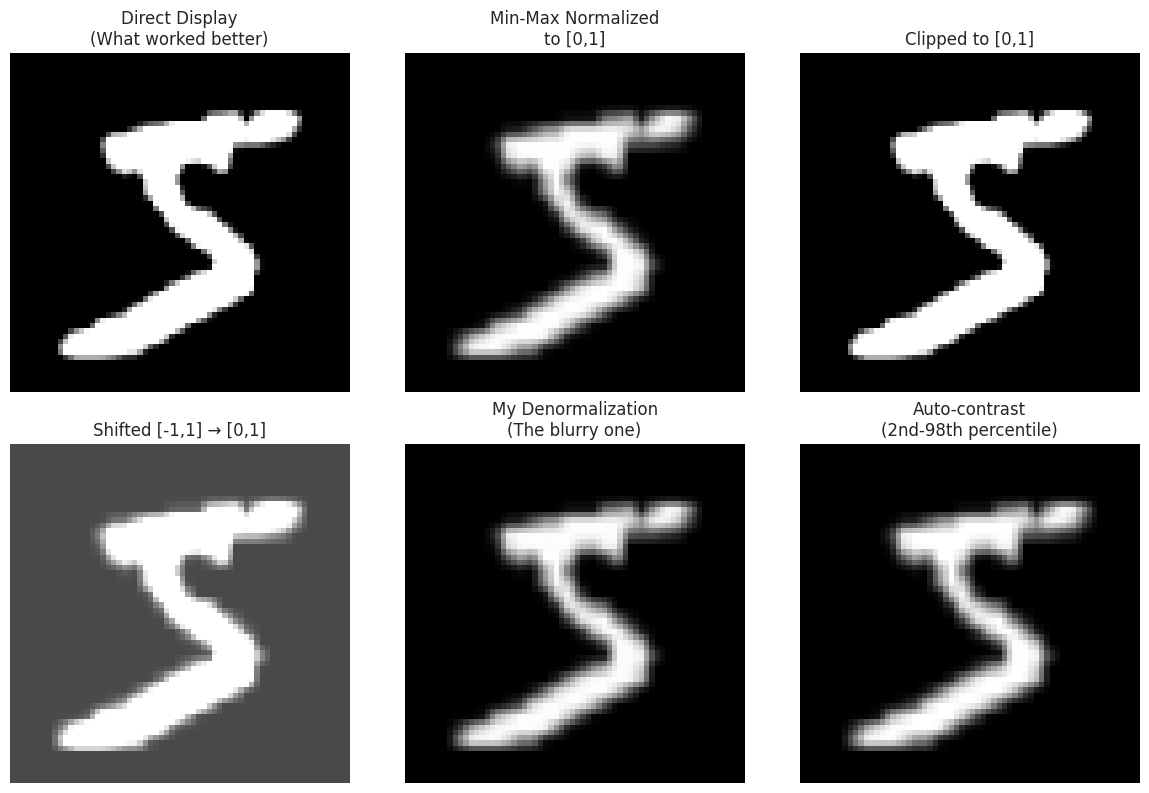

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Value ranges for each method:
Direct: [-0.424, 2.796]
Min-max: [0.000, 1.000]
Clipped: [0.000, 1.000]
Shifted: [0.288, 1.898]
Denormalized: [0.000, 0.992]
Auto-contrast: [0.000, 1.000]


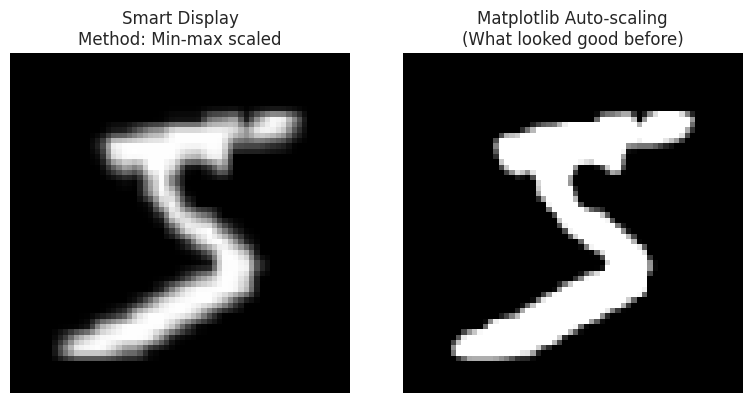

Smart display range: [0.000, 1.000]
Original range: [-0.424, 2.796]


In [4]:
# Let's investigate what's actually happening with the normalization
print("=== INVESTIGATING IMAGE NORMALIZATION ===")

from scenarios.datasets.mnist import load_mnist_with_resize
train_mnist_test, _ = load_mnist_with_resize(balanced=False, number_of_samples_per_class=None)
img, label = train_mnist_test[0]

print(f"Image stats after transforms:")
print(f"  Shape: {img.shape}")
print(f"  Min: {img.min():.4f}")
print(f"  Max: {img.max():.4f}")
print(f"  Mean: {img.mean():.4f}")
print(f"  Std: {img.std():.4f}")

# Let's also check what the transform actually does
from scenarios.datasets.mnist import train_transform_with_resize
print(f"\nActual transform pipeline:")
for i, transform in enumerate(train_transform_with_resize.transforms):
    print(f"  {i}: {transform}")

# Test different display methods
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Method 1: Direct display (what we saw works better)
img_np = img.numpy() if torch.is_tensor(img) else img
if len(img_np.shape) == 3:
    img_display = np.transpose(img_np, (1, 2, 0))
else:
    img_display = img_np

axes[0, 0].imshow(img_display.squeeze(), cmap='gray')
axes[0, 0].set_title('Direct Display\n(What worked better)')
axes[0, 0].axis('off')

# Method 2: Min-max normalization to [0,1]
img_minmax = (img_display - img_display.min()) / (img_display.max() - img_display.min())
axes[0, 1].imshow(img_minmax.squeeze(), cmap='gray', vmin=0, vmax=1)
axes[0, 1].set_title('Min-Max Normalized\nto [0,1]')
axes[0, 1].axis('off')

# Method 3: Clip to [0,1] range
img_clipped = np.clip(img_display, 0, 1)
axes[0, 2].imshow(img_clipped.squeeze(), cmap='gray', vmin=0, vmax=1)
axes[0, 2].set_title('Clipped to [0,1]')
axes[0, 2].axis('off')

# Method 4: Add offset and scale
img_shifted = (img_display + 1) / 2  # Shift from [-1,1] to [0,1]
axes[1, 0].imshow(np.clip(img_shifted.squeeze(), 0, 1), cmap='gray', vmin=0, vmax=1)
axes[1, 0].set_title('Shifted [-1,1] → [0,1]')
axes[1, 0].axis('off')

# Method 5: My denormalization attempt (the blurry one)
img_denorm = denormalize_image(img, "MNIST")
img_denorm_np = img_denorm.numpy() if torch.is_tensor(img_denorm) else img_denorm
if len(img_denorm_np.shape) == 3:
    img_denorm_display = np.transpose(img_denorm_np, (1, 2, 0))
else:
    img_denorm_display = img_denorm_np
axes[1, 1].imshow(np.clip(img_denorm_display.squeeze(), 0, 1), cmap='gray', vmin=0, vmax=1)
axes[1, 1].set_title('My Denormalization\n(The blurry one)')
axes[1, 1].axis('off')

# Method 6: Auto-contrast
img_auto = img_display.squeeze()
p2, p98 = np.percentile(img_auto, (2, 98))
img_auto = np.clip((img_auto - p2) / (p98 - p2), 0, 1)
axes[1, 2].imshow(img_auto, cmap='gray', vmin=0, vmax=1)
axes[1, 2].set_title('Auto-contrast\n(2nd-98th percentile)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Print value ranges for each method
print(f"\nValue ranges for each method:")
print(f"Direct: [{img_display.min():.3f}, {img_display.max():.3f}]")
print(f"Min-max: [{img_minmax.min():.3f}, {img_minmax.max():.3f}]")
print(f"Clipped: [{img_clipped.min():.3f}, {img_clipped.max():.3f}]")
print(f"Shifted: [{img_shifted.min():.3f}, {img_shifted.max():.3f}]")
print(f"Denormalized: [{img_denorm_display.min():.3f}, {img_denorm_display.max():.3f}]")
print(f"Auto-contrast: [{img_auto.min():.3f}, {img_auto.max():.3f}]")

def smart_display_image(img, title="", cmap='gray'):
    """
    Smart image display that automatically handles different value ranges
    """
    if torch.is_tensor(img):
        img = img.numpy()
    
    # Convert from CHW to HWC if needed
    if len(img.shape) == 3 and img.shape[0] in [1, 3]:
        img = np.transpose(img, (1, 2, 0))
    
    # Squeeze single channels
    img = img.squeeze()
    
    # Check value range and apply appropriate scaling
    img_min, img_max = img.min(), img.max()
    
    if img_min >= 0 and img_max <= 1:
        # Already in [0,1] range
        display_img = img
        method = "Direct (already [0,1])"
    elif img_min >= -1 and img_max <= 1:
        # Likely normalized to [-1,1], shift to [0,1]
        display_img = (img + 1) / 2
        method = "Shifted [-1,1] → [0,1]"
    elif img_min < 0:
        # Has negative values, probably normalized, use min-max scaling
        display_img = (img - img_min) / (img_max - img_min)
        method = "Min-max scaled"
    else:
        # Positive values > 1, probably need scaling
        display_img = img / img_max
        method = "Scaled by max"
    
    return display_img, method

# Test the smart display function
img, label = train_mnist_test[0]
display_img, method = smart_display_image(img)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(display_img, cmap='gray', vmin=0, vmax=1)
plt.title(f'Smart Display\nMethod: {method}')
plt.axis('off')

# Compare with direct matplotlib display (auto-scaling)
img_np = img.numpy() if torch.is_tensor(img) else img
img_display = np.transpose(img_np, (1, 2, 0)) if len(img_np.shape) == 3 else img_np
plt.subplot(1, 2, 2)
plt.imshow(img_display.squeeze(), cmap='gray')
plt.title('Matplotlib Auto-scaling\n(What looked good before)')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Smart display range: [{display_img.min():.3f}, {display_img.max():.3f}]")
print(f"Original range: [{img.min():.3f}, {img.max():.3f}]")

Loading MNIST dataset...
MNIST Train size: 60000
MNIST Test size: 10000

ANALYZING MNIST TRAIN
Dataset size: 60000
Number of classes: 10
Class range: 0 to 9
Class distribution:
  Class 0: 5923 samples
  Class 1: 6742 samples
  Class 2: 5958 samples
  Class 3: 6131 samples
  Class 4: 5842 samples
  Class 5: 5421 samples
  Class 6: 5918 samples
  Class 7: 6265 samples
  Class 8: 5851 samples
  Class 9: 5949 samples
Image shape: torch.Size([3, 64, 64])
Image type: <class 'torch.Tensor'>
Sample image value range: [-0.424, 2.796]


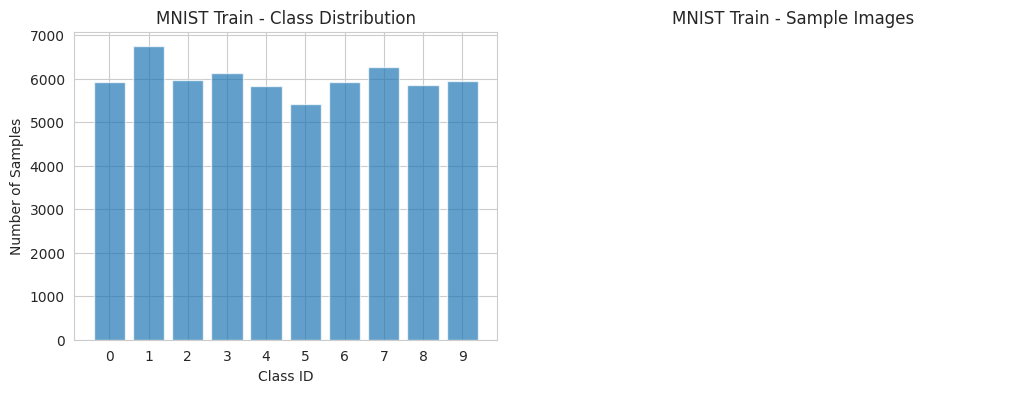

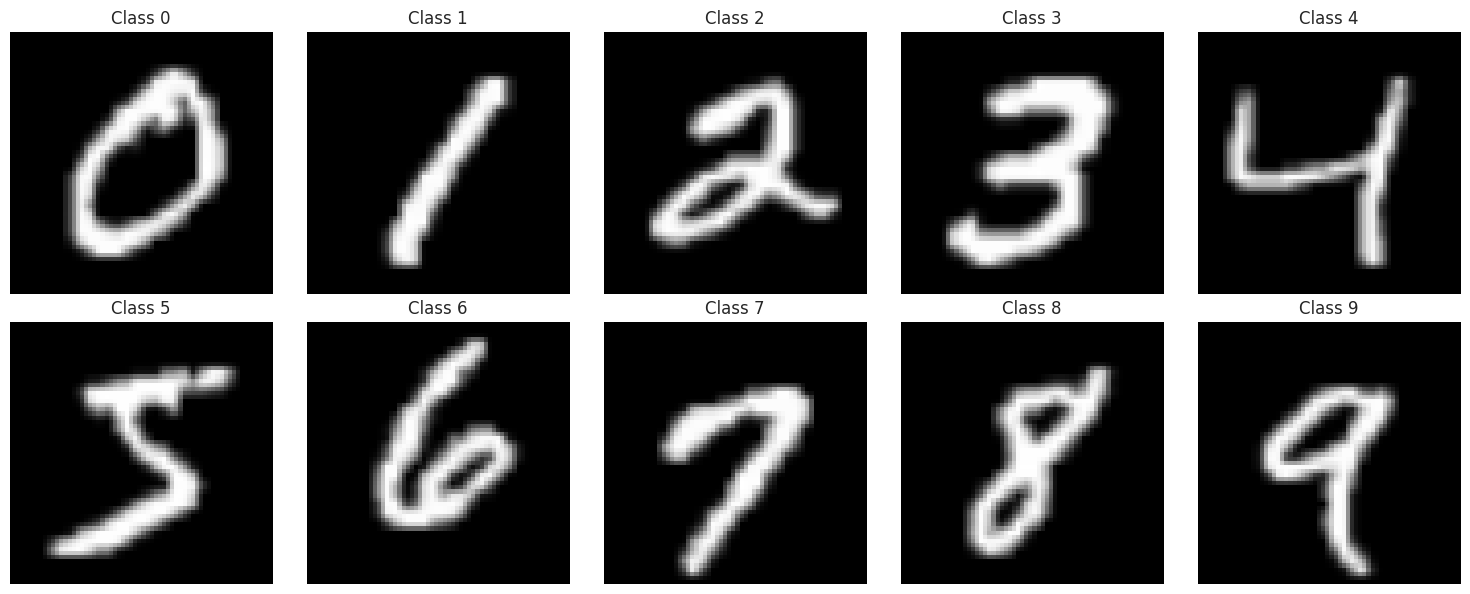

In [5]:
# Load MNIST dataset
from scenarios.datasets.mnist import load_mnist_with_resize

print("Loading MNIST dataset...")
train_mnist, test_mnist = load_mnist_with_resize(balanced=False, number_of_samples_per_class=None)

print(f"MNIST Train size: {len(train_mnist)}")
print(f"MNIST Test size: {len(test_mnist)}")

# Analyze train set
mnist_stats = analyze_dataset(train_mnist, "MNIST Train", num_examples_per_class=3)


ANALYZING MNIST TRAIN
Dataset size: 60000
Number of classes: 10
Class range: 0 to 9
Class distribution:
  Class 0: 5923 samples
  Class 1: 6742 samples
  Class 2: 5958 samples
  Class 3: 6131 samples
  Class 4: 5842 samples
  Class 5: 5421 samples
  Class 6: 5918 samples
  Class 7: 6265 samples
  Class 8: 5851 samples
  Class 9: 5949 samples
Image shape: torch.Size([3, 64, 64])
Image type: <class 'torch.Tensor'>
Sample image value range: [-0.424, 2.796]
Debug - Original shape: (3, 64, 64), dtype: float32
Debug - Value range: [-0.424, 2.811]
Debug - Transposed to: (64, 64, 3)
Debug - Unknown range, normalizing from [-0.4242129623889923, 2.810908794403076]
Debug - Final shape: (64, 64, 3), range: [0.000, 1.000]
Debug - Original shape: (3, 64, 64), dtype: float32
Debug - Value range: [-0.424, 2.812]
Debug - Transposed to: (64, 64, 3)
Debug - Unknown range, normalizing from [-0.4242129623889923, 2.8119404315948486]
Debug - Final shape: (64, 64, 3), range: [0.000, 1.000]
Debug - Original s

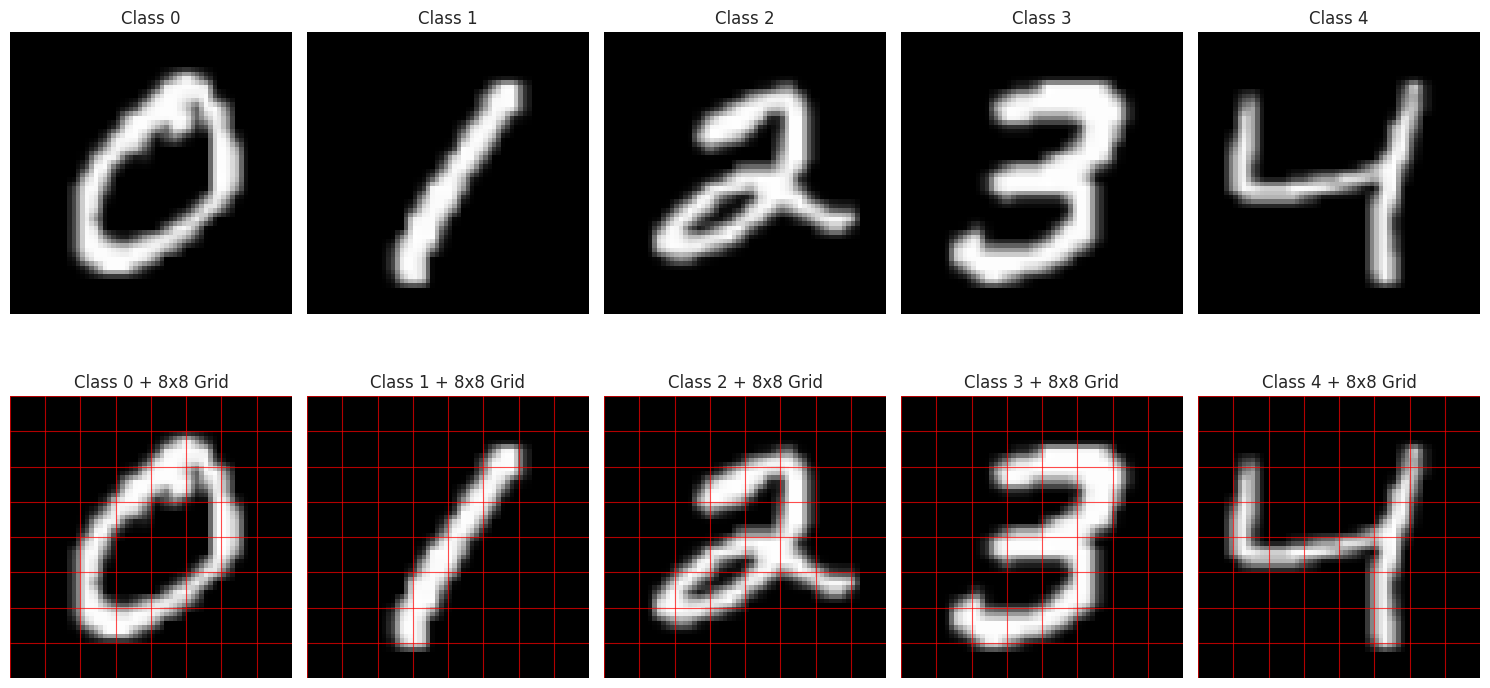

Debug - Original shape: (3, 64, 64), dtype: float32
Debug - Value range: [-0.424, 2.811]
Debug - Transposed to: (64, 64, 3)
Debug - Unknown range, normalizing from [-0.4242129623889923, 2.810908794403076]
Debug - Final shape: (64, 64, 3), range: [0.000, 1.000]
Debug - Original shape: (3, 64, 64), dtype: float32
Debug - Value range: [-0.424, 2.812]
Debug - Transposed to: (64, 64, 3)
Debug - Unknown range, normalizing from [-0.4242129623889923, 2.8119404315948486]
Debug - Final shape: (64, 64, 3), range: [0.000, 1.000]
Debug - Original shape: (3, 64, 64), dtype: float32
Debug - Value range: [-0.424, 2.796]
Debug - Transposed to: (64, 64, 3)
Debug - Unknown range, normalizing from [-0.4242129623889923, 2.7955825328826904]
Debug - Final shape: (64, 64, 3), range: [0.000, 1.000]


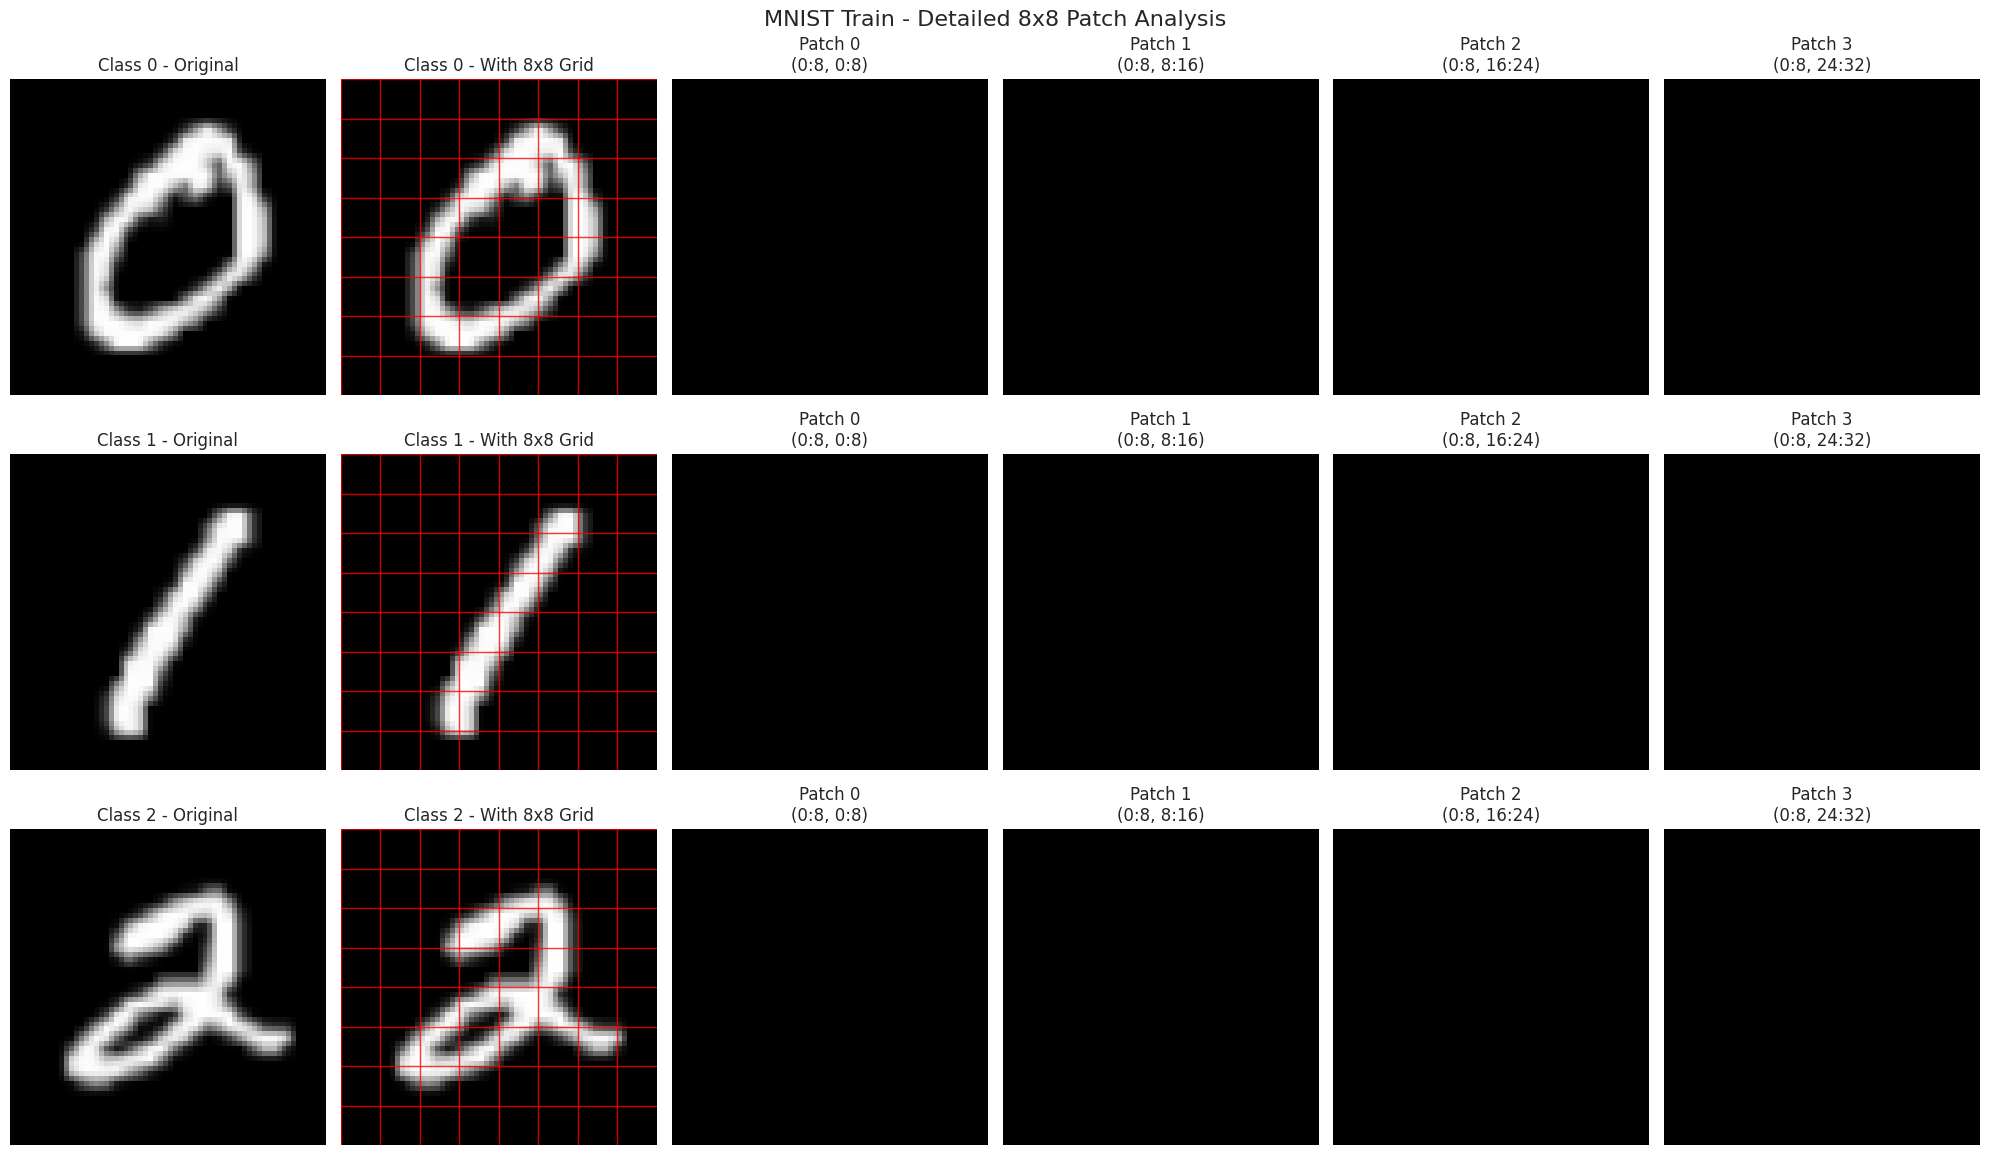

In [11]:
def analyze_dataset_with_patches(dataset, dataset_name, num_examples_per_class=5, max_classes_to_show=10, patch_size=8):
    """
    Comprehensive analysis of a dataset with smart image display and 8x8 patch visualization
    """
    print(f"\n{'='*60}")
    print(f"ANALYZING {dataset_name.upper()}")
    print(f"{'='*60}")
    
    # Basic statistics
    print(f"Dataset size: {len(dataset)}")
    
    # Get targets/labels
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
    elif hasattr(dataset, 'labels'):
        targets = dataset.labels
    else:
        # Extract targets from dataset
        targets = [dataset[i][1] for i in range(len(dataset))]
    
    if torch.is_tensor(targets):
        targets = targets.numpy()
    
    unique_classes = np.unique(targets)
    class_counts = Counter(targets)
    
    print(f"Number of classes: {len(unique_classes)}")
    print(f"Class range: {min(unique_classes)} to {max(unique_classes)}")
    print(f"Class distribution:")
    for class_id in sorted(unique_classes):
        print(f"  Class {class_id}: {class_counts[class_id]} samples")
    
    # Get sample image to determine shape
    sample_img, sample_label = dataset[0]
    if torch.is_tensor(sample_img):
        img_shape = sample_img.shape
    else:
        img_shape = np.array(sample_img).shape
    
    print(f"Image shape: {img_shape}")
    print(f"Image type: {type(sample_img)}")
    
    # Check image value range
    sample_min = sample_img.min().item() if torch.is_tensor(sample_img) else np.min(sample_img)
    sample_max = sample_img.max().item() if torch.is_tensor(sample_img) else np.max(sample_img)
    print(f"Sample image value range: [{sample_min:.3f}, {sample_max:.3f}]")
    
    # Plot class distribution
    plt.figure(figsize=(15, 8))
    
    plt.subplot(2, 3, 1)
    classes, counts = zip(*sorted(class_counts.items()))
    plt.bar(classes, counts, alpha=0.7)
    plt.title(f'{dataset_name} - Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Samples')
    plt.xticks(classes)
    
    # Show sample images (original)
    classes_to_show = min(max_classes_to_show, len(unique_classes))
    
    # Original images
    plt.subplot(2, 3, 2)
    plt.title(f'{dataset_name} - Original Images')
    
    # Create a grid for original images
    rows_orig = min(2, int(np.ceil(classes_to_show / 5)))
    cols_orig = min(5, classes_to_show)
    
    for idx, class_id in enumerate(sorted(unique_classes)[:min(10, classes_to_show)]):
        if idx >= 10:  # Limit to 10 for space
            break
            
        # Find first occurrence of this class
        class_indices = [i for i, target in enumerate(targets) if target == class_id]
        
        if class_indices:
            img, label = dataset[class_indices[0]]
            
            # Use smart display
            img_display, display_method = smart_display_image(img)
            
            plt.subplot(2, 5, idx + 1)
            if len(img_display.shape) == 2:  # Grayscale
                plt.imshow(img_display, cmap='gray', vmin=0, vmax=1)
            elif len(img_display.shape) == 3 and img_display.shape[2] == 1:
                plt.imshow(img_display.squeeze(), cmap='gray', vmin=0, vmax=1)
            else:  # RGB
                plt.imshow(img_display)
                
            plt.title(f'Class {class_id}')
            plt.axis('off')
    
    # Images with 8x8 grid overlay
    for idx, class_id in enumerate(sorted(unique_classes)[:5]):  # Show first 5 classes with patches
        class_indices = [i for i, target in enumerate(targets) if target == class_id]
        
        if class_indices:
            img, label = dataset[class_indices[0]]
            img_display, display_method = smart_display_image(img)
            
            plt.subplot(2, 5, idx + 6)
            
            # Display image
            if len(img_display.shape) == 2:  # Grayscale
                plt.imshow(img_display, cmap='gray', vmin=0, vmax=1)
                h, w = img_display.shape
            elif len(img_display.shape) == 3 and img_display.shape[2] == 1:
                plt.imshow(img_display.squeeze(), cmap='gray', vmin=0, vmax=1)
                h, w = img_display.shape[:2]
            else:  # RGB
                plt.imshow(img_display)
                h, w = img_display.shape[:2]
            
            # Add 8x8 grid overlay
            for x in range(0, w, patch_size):
                plt.axvline(x - 0.5, color='red', linewidth=0.8, alpha=0.7)
            for y in range(0, h, patch_size):
                plt.axhline(y - 0.5, color='red', linewidth=0.8, alpha=0.7)
            
            plt.title(f'Class {class_id} + {patch_size}x{patch_size} Grid')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show detailed patch analysis for one sample
    show_patch_analysis(dataset, targets, unique_classes, patch_size, dataset_name)
    
    return {
        'size': len(dataset),
        'num_classes': len(unique_classes),
        'class_counts': class_counts,
        'image_shape': img_shape,
        'classes': unique_classes
    }

def show_patch_analysis(dataset, targets, unique_classes, patch_size, dataset_name):
    """
    Show detailed 8x8 patch analysis for sample images
    """
    plt.figure(figsize=(20, 12))
    
    # Select 3 different classes for detailed analysis
    sample_classes = sorted(unique_classes)[:3]
    
    for class_idx, class_id in enumerate(sample_classes):
        # Find first occurrence of this class
        class_indices = [i for i, target in enumerate(targets) if target == class_id]
        
        if class_indices:
            img, label = dataset[class_indices[0]]
            img_display, display_method = smart_display_image(img)
            
            if len(img_display.shape) == 3 and img_display.shape[2] == 1:
                img_display = img_display.squeeze()
            
            h, w = img_display.shape[:2]
            
            # Original image
            plt.subplot(3, 6, class_idx * 6 + 1)
            plt.imshow(img_display, cmap='gray' if len(img_display.shape) == 2 else None, vmin=0, vmax=1)
            plt.title(f'Class {class_id} - Original')
            plt.axis('off')
            
            # Image with grid
            plt.subplot(3, 6, class_idx * 6 + 2)
            plt.imshow(img_display, cmap='gray' if len(img_display.shape) == 2 else None, vmin=0, vmax=1)
            
            # Add grid
            for x in range(0, w, patch_size):
                plt.axvline(x - 0.5, color='red', linewidth=1, alpha=0.8)
            for y in range(0, h, patch_size):
                plt.axhline(y - 0.5, color='red', linewidth=1, alpha=0.8)
                
            plt.title(f'Class {class_id} - With {patch_size}x{patch_size} Grid')
            plt.axis('off')
            
            # Extract and show individual patches
            patches = extract_patches(img_display, patch_size)
            
            # Show first 4 patches
            for patch_idx in range(min(4, len(patches))):
                plt.subplot(3, 6, class_idx * 6 + 3 + patch_idx)
                patch = patches[patch_idx]
                plt.imshow(patch, cmap='gray' if len(patch.shape) == 2 else None, vmin=0, vmax=1)
                
                # Calculate patch position
                patches_per_row = w // patch_size
                row = patch_idx // patches_per_row
                col = patch_idx % patches_per_row
                
                plt.title(f'Patch {patch_idx}\n({row*patch_size}:{(row+1)*patch_size}, {col*patch_size}:{(col+1)*patch_size})')
                plt.axis('off')
    
    plt.suptitle(f'{dataset_name} - Detailed {patch_size}x{patch_size} Patch Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()

def extract_patches(image, patch_size):
    """
    Extract patches from an image
    """
    if len(image.shape) == 2:
        h, w = image.shape
    else:
        h, w = image.shape[:2]
    
    patches = []
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            # Handle edge cases where image size is not divisible by patch_size
            y_end = min(y + patch_size, h)
            x_end = min(x + patch_size, w)
            
            if len(image.shape) == 2:
                patch = image[y:y_end, x:x_end]
            else:
                patch = image[y:y_end, x:x_end, :]
            
            # Only include patches that are exactly patch_size x patch_size
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    
    return patches

def smart_display_image(img):
    """
    Smart image display function that properly handles different image formats
    """
    # Convert to numpy if tensor
    if torch.is_tensor(img):
        img_np = img.detach().cpu().numpy()
    else:
        img_np = np.array(img)
    
    # Print debug info
    print(f"Debug - Original shape: {img_np.shape}, dtype: {img_np.dtype}")
    print(f"Debug - Value range: [{img_np.min():.3f}, {img_np.max():.3f}]")
    
    # Handle different tensor formats
    if len(img_np.shape) == 3:
        if img_np.shape[0] == 1:  # (1, H, W) - single channel
            img_np = img_np.squeeze(0)
            print(f"Debug - Squeezed to: {img_np.shape}")
        elif img_np.shape[0] == 3:  # (3, H, W) RGB
            img_np = np.transpose(img_np, (1, 2, 0))
            print(f"Debug - Transposed to: {img_np.shape}")
        elif img_np.shape[2] == 1:  # (H, W, 1)
            img_np = img_np.squeeze(2)
            print(f"Debug - Squeezed last dim to: {img_np.shape}")
    
    # Handle normalization more carefully
    if img_np.max() <= 1.0 and img_np.min() >= 0.0:
        # Already in [0,1] range
        print("Debug - Image already in [0,1] range")
        display_img = img_np
    elif img_np.max() <= 255.0 and img_np.min() >= 0.0:
        # In [0,255] range, normalize to [0,1]
        print("Debug - Normalizing from [0,255] to [0,1]")
        display_img = img_np / 255.0
    else:
        # Unknown range, try to normalize
        print(f"Debug - Unknown range, normalizing from [{img_np.min()}, {img_np.max()}]")
        if img_np.max() != img_np.min():
            display_img = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        else:
            display_img = img_np
    
    print(f"Debug - Final shape: {display_img.shape}, range: [{display_img.min():.3f}, {display_img.max():.3f}]")
    
    return display_img, "normalized"

# Simple debugging function to check MNIST data
def debug_mnist_sample(dataset, index=0):
    """
    Debug function to understand MNIST data format
    """
    img, label = dataset[index]
    
    print(f"Image type: {type(img)}")
    print(f"Label: {label}")
    
    if torch.is_tensor(img):
        print(f"Tensor shape: {img.shape}")
        print(f"Tensor dtype: {img.dtype}")
        print(f"Tensor device: {img.device}")
        print(f"Value range: [{img.min().item():.3f}, {img.max().item():.3f}]")
        
        # Convert to numpy for visualization
        img_np = img.detach().cpu().numpy()
    else:
        img_np = np.array(img)
        print(f"Array shape: {img_np.shape}")
        print(f"Array dtype: {img_np.dtype}")
        print(f"Value range: [{img_np.min():.3f}, {img_np.max():.3f}]")
    
    # Try different display methods
    plt.figure(figsize=(15, 3))
    
    # Method 1: Direct display
    plt.subplot(1, 5, 1)
    if len(img_np.shape) == 3 and img_np.shape[0] == 1:
        plt.imshow(img_np.squeeze(0), cmap='gray')
    elif len(img_np.shape) == 3 and img_np.shape[2] == 1:
        plt.imshow(img_np.squeeze(2), cmap='gray')
    else:
        plt.imshow(img_np, cmap='gray')
    plt.title('Method 1: Direct')
    plt.axis('off')
    
    # Method 2: Ensure 2D and normalize
    plt.subplot(1, 5, 2)
    if len(img_np.shape) == 3:
        img_2d = img_np.squeeze()
    else:
        img_2d = img_np
    
    if img_2d.max() > 1:
        img_2d = img_2d / 255.0
    
    plt.imshow(img_2d, cmap='gray', vmin=0, vmax=1)
    plt.title('Method 2: Normalized')
    plt.axis('off')
    
    # Method 3: Force contrast
    plt.subplot(1, 5, 3)
    img_contrast = (img_2d - img_2d.min()) / (img_2d.max() - img_2d.min()) if img_2d.max() != img_2d.min() else img_2d
    plt.imshow(img_contrast, cmap='gray')
    plt.title('Method 3: Contrast')
    plt.axis('off')
    
    # Method 4: Inverted (in case it's white on black)
    plt.subplot(1, 5, 4)
    plt.imshow(1 - img_contrast, cmap='gray')
    plt.title('Method 4: Inverted')
    plt.axis('off')
    
    # Method 5: Raw values as heatmap
    plt.subplot(1, 5, 5)
    plt.imshow(img_2d, cmap='viridis')
    plt.title('Method 5: Heatmap')
    plt.colorbar()
    plt.axis('off')
    
    plt.suptitle(f'MNIST Sample {index} - Label: {label}')
    plt.tight_layout()
    plt.show()
    
    return img_2d

# Usage example:
# First debug the data format:
# debug_mnist_sample(train_mnist, 0)

# Then use the enhanced analysis:
mnist_stats = analyze_dataset_with_patches(train_mnist, "MNIST Train", patch_size=8)

Loading Fashion-MNIST dataset...
Fashion-MNIST Train size: 60000
Fashion-MNIST Test size: 10000
Fashion-MNIST class mapping:
  0: T-shirt/top
  1: Trouser
  2: Pullover
  3: Dress
  4: Coat
  5: Sandal
  6: Shirt
  7: Sneaker
  8: Bag
  9: Ankle boot

ANALYZING FASHION-MNIST TRAIN
Dataset size: 60000
Number of classes: 10
Class range: 0 to 9
Class distribution:
  Class 0: 6000 samples
  Class 1: 6000 samples
  Class 2: 6000 samples
  Class 3: 6000 samples
  Class 4: 6000 samples
  Class 5: 6000 samples
  Class 6: 6000 samples
  Class 7: 6000 samples
  Class 8: 6000 samples
  Class 9: 6000 samples
Image shape: torch.Size([3, 64, 64])
Image type: <class 'torch.Tensor'>
Sample image value range: [-0.424, 2.762]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

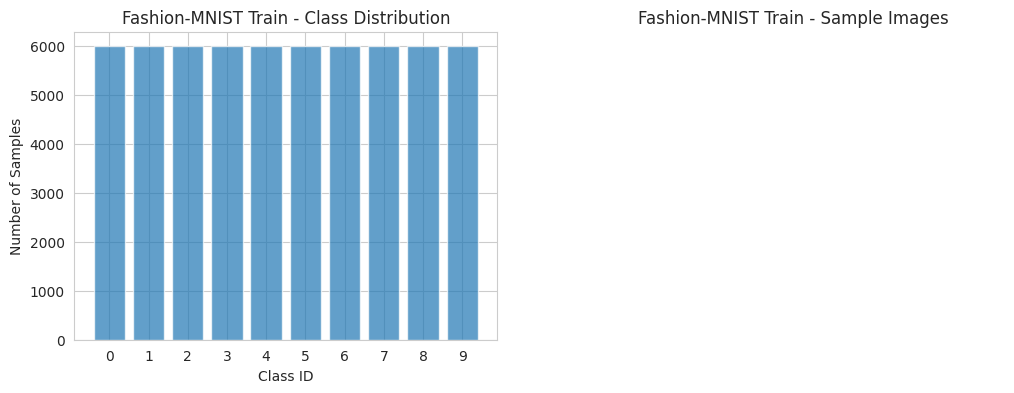

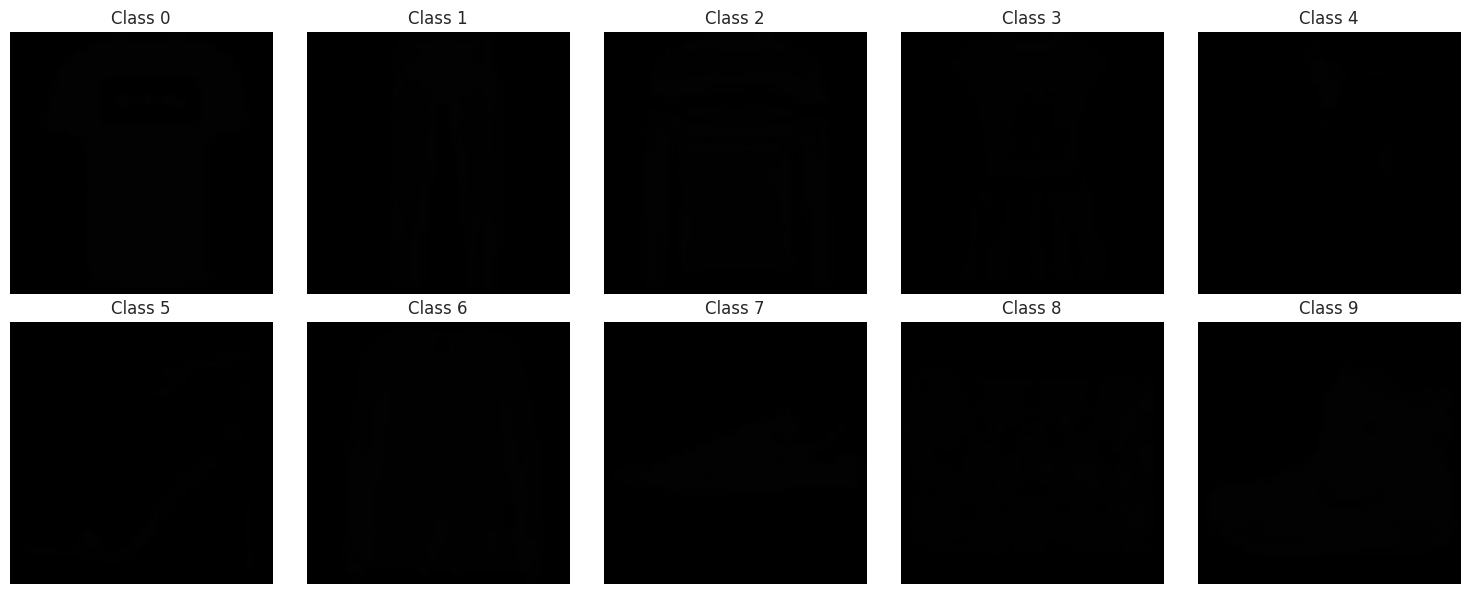

In [7]:
# Load Fashion-MNIST dataset
from scenarios.datasets.fashion_mnist import load_fashion_mnist_with_resize

print("Loading Fashion-MNIST dataset...")
train_fashion, test_fashion = load_fashion_mnist_with_resize(balanced=False, number_of_samples_per_class=None)

print(f"Fashion-MNIST Train size: {len(train_fashion)}")
print(f"Fashion-MNIST Test size: {len(test_fashion)}")

# Fashion-MNIST class names
fashion_class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

print("Fashion-MNIST class mapping:")
for i, name in enumerate(fashion_class_names):
    print(f"  {i}: {name}")

# Analyze train set
fashion_stats = analyze_dataset(train_fashion, "Fashion-MNIST Train", num_examples_per_class=3)

Loading SVHN dataset...
Using downloaded and verified file: /home/brothen/M2I_I2M_benchmark/data/train_32x32.mat
Using downloaded and verified file: /home/brothen/M2I_I2M_benchmark/data/test_32x32.mat
SVHN Train size: 73257
SVHN Test size: 26032
SVHN class mapping (digit recognition):
  0: Digit 0
  1: Digit 1
  2: Digit 2
  3: Digit 3
  4: Digit 4
  5: Digit 5
  6: Digit 6
  7: Digit 7
  8: Digit 8
  9: Digit 9

ANALYZING SVHN TRAIN
Dataset size: 73257
Number of classes: 10
Class range: 0 to 9
Class distribution:
  Class 0: 4948 samples
  Class 1: 13861 samples
  Class 2: 10585 samples
  Class 3: 8497 samples
  Class 4: 7458 samples
  Class 5: 6882 samples
  Class 6: 5727 samples
  Class 7: 5595 samples
  Class 8: 5045 samples
  Class 9: 4659 samples
Image shape: torch.Size([3, 64, 64])
Image type: <class 'torch.Tensor'>
Sample image value range: [0.053, 0.439]


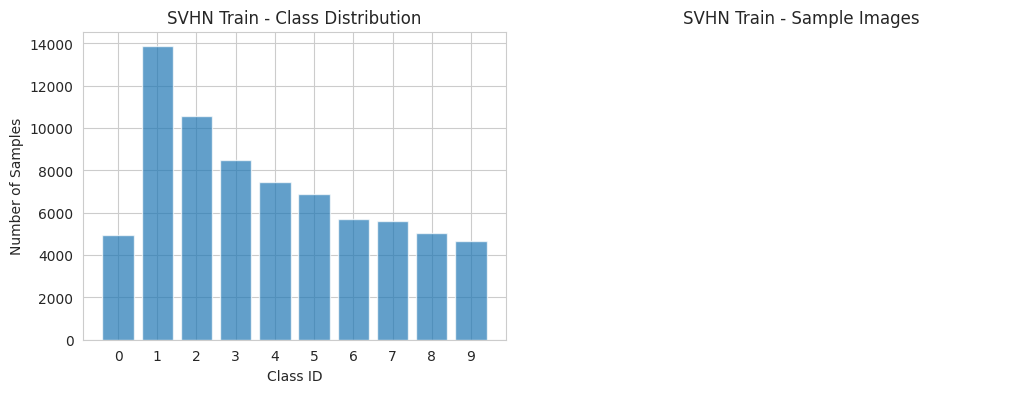

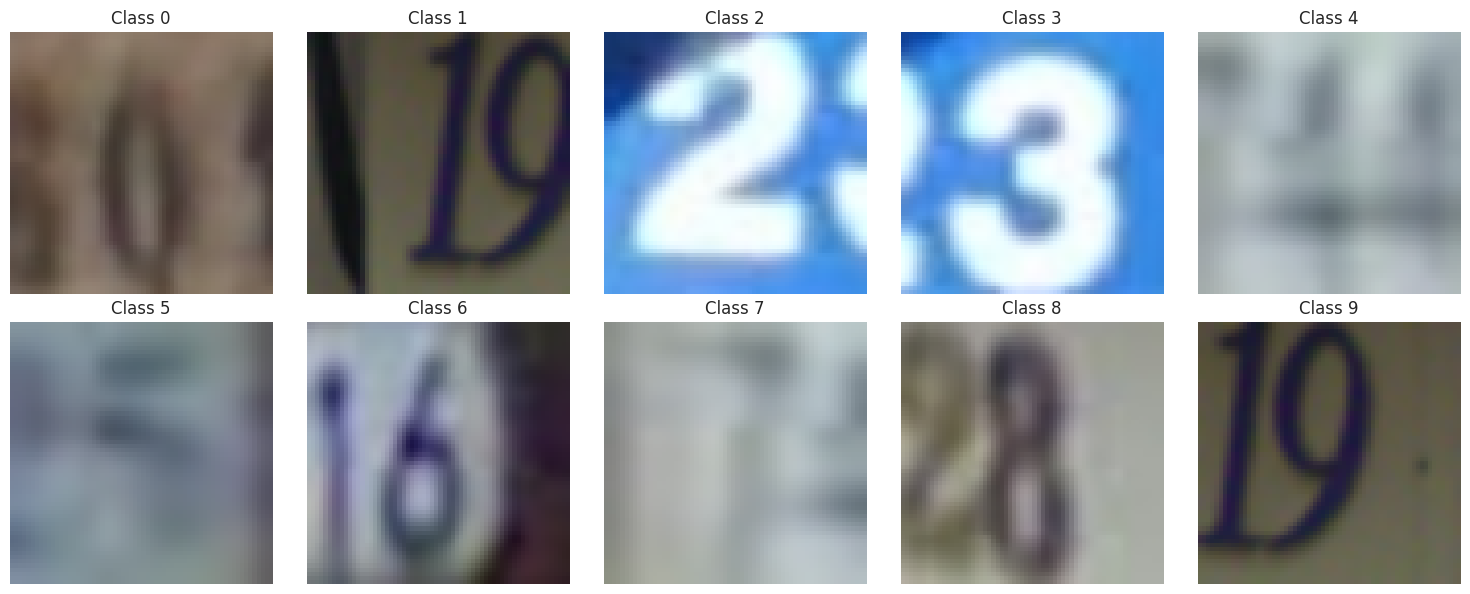

In [8]:
# Load SVHN dataset
from scenarios.datasets.svhn import load_svhn_resized

print("Loading SVHN dataset...")
train_svhn, test_svhn = load_svhn_resized(balanced=False, number_of_samples_per_class=None)

print(f"SVHN Train size: {len(train_svhn)}")
print(f"SVHN Test size: {len(test_svhn)}")

print("SVHN class mapping (digit recognition):")
for i in range(10):
    print(f"  {i}: Digit {i}")

# Analyze train set
svhn_stats = analyze_dataset(train_svhn, "SVHN Train", num_examples_per_class=3)

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CIFAR-10 Train size: 50000
CIFAR-10 Test size: 10000
CIFAR-10 class mapping:
  0: airplane
  1: automobile
  2: bird
  3: cat
  4: deer
  5: dog
  6: frog
  7: horse
  8: ship
  9: truck

ANALYZING CIFAR-10 TRAIN
Dataset size: 50000
Number of classes: 10
Class range: 0 to 9
Class distribution:
  Class 0: 5000 samples
  Class 1: 5000 samples
  Class 2: 5000 samples
  Class 3: 5000 samples
  Class 4: 5000 samples
  Class 5: 5000 samples
  Class 6: 5000 samples
  Class 7: 5000 samples
  Class 8: 5000 samples
  Class 9: 5000 samples
Image shape: torch.Size([3, 64, 64])
Image type: <class 'torch.Tensor'>
Sample image value range: [-3.432, 0.249]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


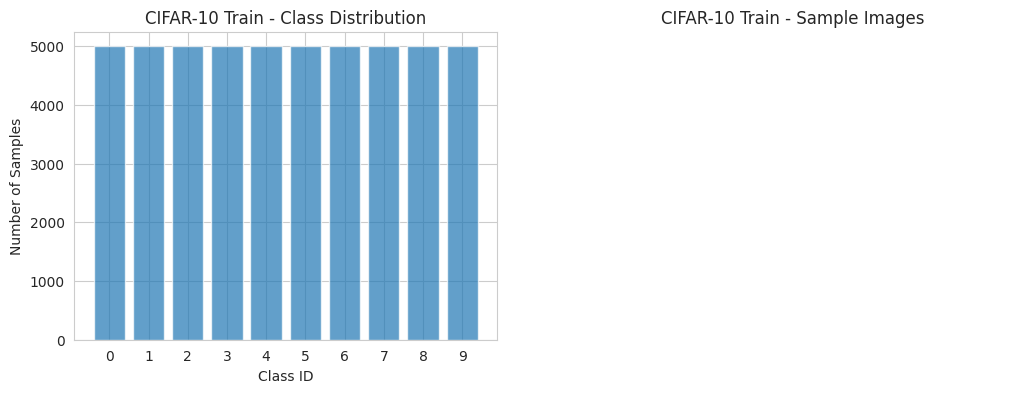

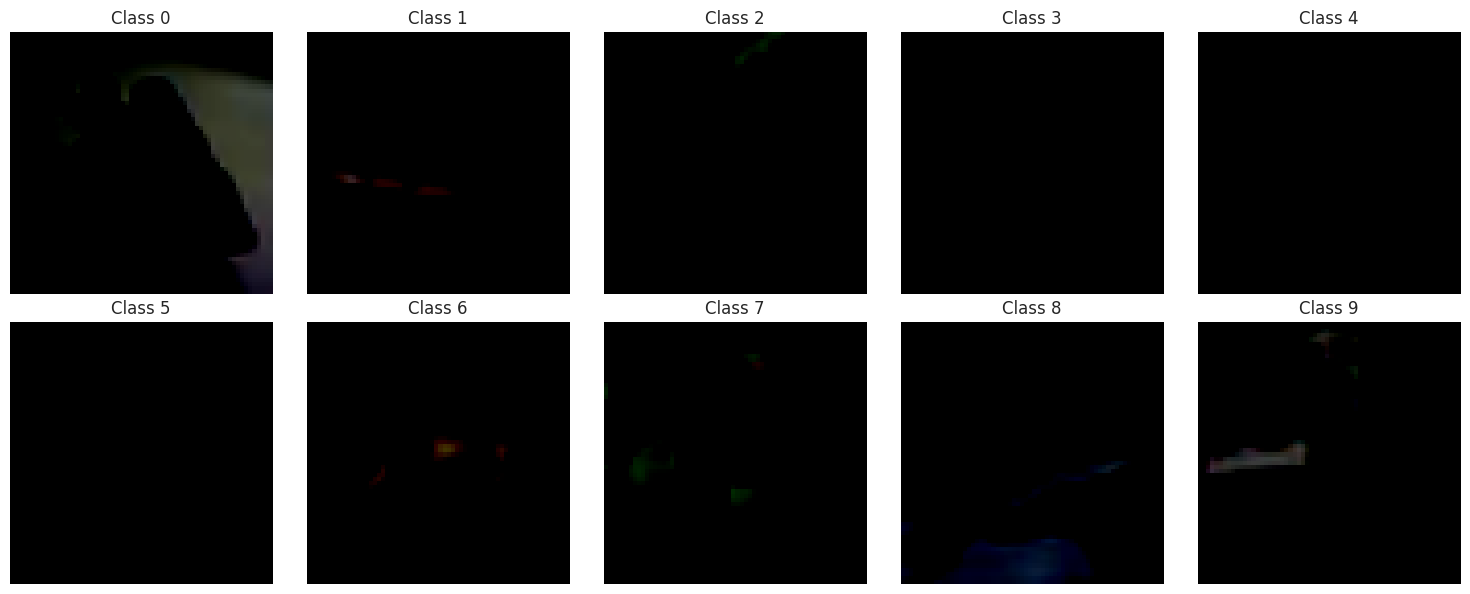

In [9]:
# Load CIFAR-10 dataset
from scenarios.datasets.cifar import load_resized_cifar10

print("Loading CIFAR-10 dataset...")
train_cifar, test_cifar = load_resized_cifar10(balanced=False, number_of_samples_per_class=None)

print(f"CIFAR-10 Train size: {len(train_cifar)}")
print(f"CIFAR-10 Test size: {len(test_cifar)}")

# CIFAR-10 class names
cifar_class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

print("CIFAR-10 class mapping:")
for i, name in enumerate(cifar_class_names):
    print(f"  {i}: {name}")

# Analyze train set
cifar_stats = analyze_dataset(train_cifar, "CIFAR-10 Train", num_examples_per_class=3)

Loading Omniglot dataset...
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Omniglot Train size (filtered): 156
Omniglot Test size (filtered): 44
Omniglot Full Train size: 10541
Omniglot Full Test size: 2636
Note: Omniglot contains characters from various alphabets
We're using first 10 classes for continual learning scenario

ANALYZING OMNIGLOT TRAIN (FILTERED)
Dataset size: 156
Number of classes: 10
Class range: 0 to 9
Class distribution:
  Class 0: 15 samples
  Class 1: 16 samples
  Class 2: 17 samples
  Class 3: 13 samples
  Class 4: 17 samples
  Class 5: 17 samples
  Class 6: 15 samples
  Class 7: 15 samples
  Class 8: 14 samples
  Class 9: 17 samples
Image shape: torch.Size([3, 64, 64])
Image type: <class 'torch.Tensor'>
Sample image value range: [-3.439, 0.291]


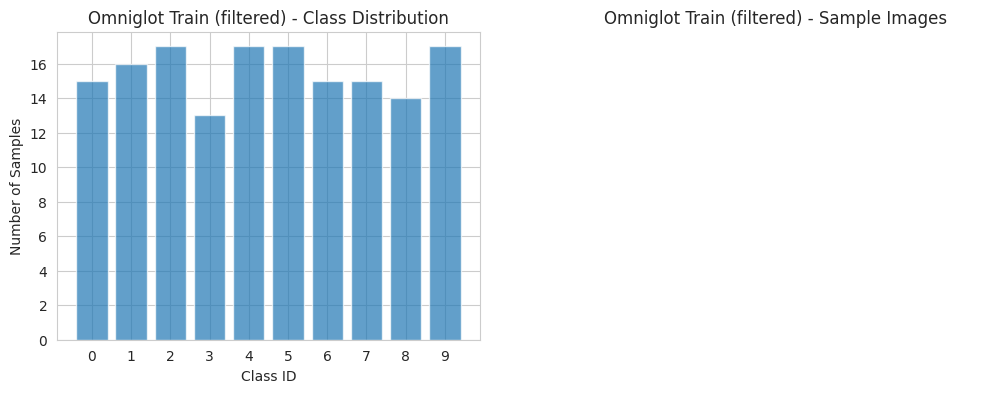

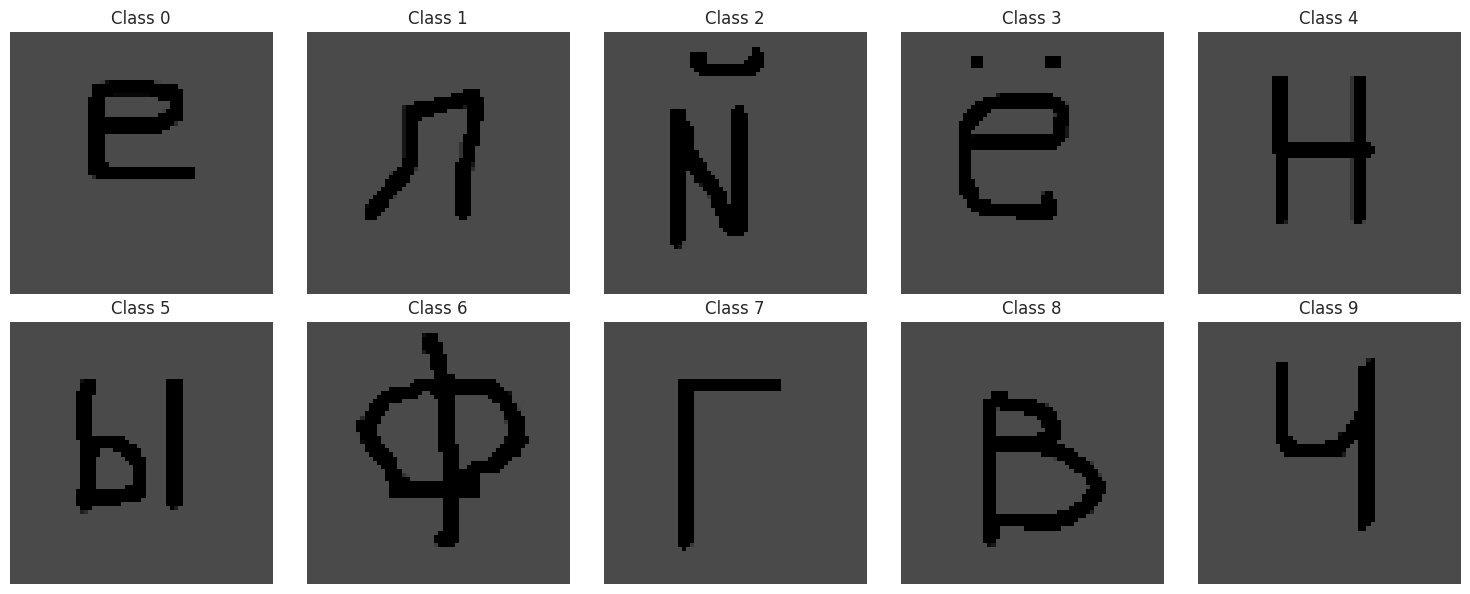

Loading Omniglot dataset WITH replacement sampling + augmentation...
Files already downloaded and verified


KeyboardInterrupt: 

In [10]:
# Load Omniglot dataset
from scenarios.datasets.omniglot import load_resized_omniglot
from scenarios.utils import filter_classes

print("Loading Omniglot dataset...")
train_omniglot_full, test_omniglot_full = load_resized_omniglot()

# Filter to first 10 classes (as used in the scenarios)
train_omniglot, test_omniglot = filter_classes(train_omniglot_full, test_omniglot_full, 
                                              classes=list(range(10)))

print(f"Omniglot Train size (filtered): {len(train_omniglot)}")
print(f"Omniglot Test size (filtered): {len(test_omniglot)}")
print(f"Omniglot Full Train size: {len(train_omniglot_full)}")
print(f"Omniglot Full Test size: {len(test_omniglot_full)}")

print("Note: Omniglot contains characters from various alphabets")
print("We're using first 10 classes for continual learning scenario")

# Analyze filtered train set
omniglot_stats = analyze_dataset(train_omniglot, "Omniglot Train (filtered)", num_examples_per_class=3)



# Load Omniglot dataset WITH REPLACEMENT SAMPLING + AUGMENTATION (NEW APPROACH)
from scenarios.datasets.omniglot import _load_omniglot
from scenarios.utils import filter_classes
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from scenarios.utils import transform_from_gray_to_rgb

print("Loading Omniglot dataset WITH replacement sampling + augmentation...")

# Use the same transform as in the real experiments
transform_with_resize = Compose([
    ToTensor(),
    Resize((64, 64)),
    transform_from_gray_to_rgb(),
    Normalize(mean=(0.9221,), std=(0.2681,))
])

# NEW: Load with balanced=True and 500 samples per class (triggers replacement sampling)
train_omniglot_full, test_omniglot_full = _load_omniglot(
    transform_with_resize, 
    balanced=True, 
    number_of_samples_per_class=500
)

# Filter to first 10 classes (as used in the scenarios)
train_omniglot, test_omniglot = filter_classes(train_omniglot_full, test_omniglot_full, 
                                              classes=list(range(10)))

print(f"Omniglot Train size (filtered): {len(train_omniglot)}")
print(f"Omniglot Test size (filtered): {len(test_omniglot)}")
print(f"Expected: 10 classes × 500 samples = 5000 train samples")

print("Note: Omniglot originally has ~20 samples per class")
print("With replacement sampling + augmentation, we stretch it to 500 per class")

# Analyze filtered train set
omniglot_stats = analyze_dataset(train_omniglot, "Omniglot Train (with replacement sampling)", num_examples_per_class=3)

Loading TinyImageNet dataset...
Files already downloaded and verified
Files already downloaded and verified
TinyImageNet Train size (filtered): 5000
TinyImageNet Test size (filtered): 500
TinyImageNet Full Train size: 100000
TinyImageNet Full Test size: 10000
Note: TinyImageNet is a subset of ImageNet with 200 classes
We're using first 10 classes for continual learning scenario

ANALYZING TINYIMAGENET TRAIN (FILTERED)
Dataset size: 5000
Number of classes: 10
Class range: 0 to 9
Class distribution:
  Class 0: 500 samples
  Class 1: 500 samples
  Class 2: 500 samples
  Class 3: 500 samples
  Class 4: 500 samples
  Class 5: 500 samples
  Class 6: 500 samples
  Class 7: 500 samples
  Class 8: 500 samples
  Class 9: 500 samples
Image shape: torch.Size([3, 64, 64])
Image type: <class 'torch.Tensor'>
Sample image value range: [0.000, 0.902]


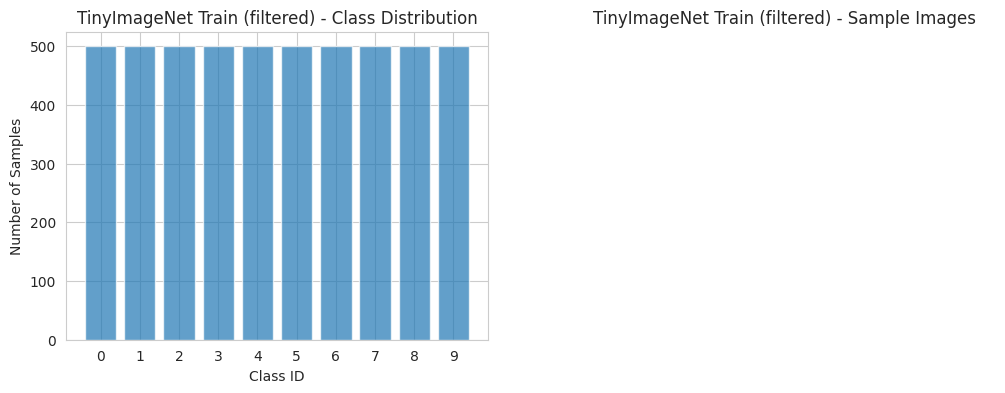

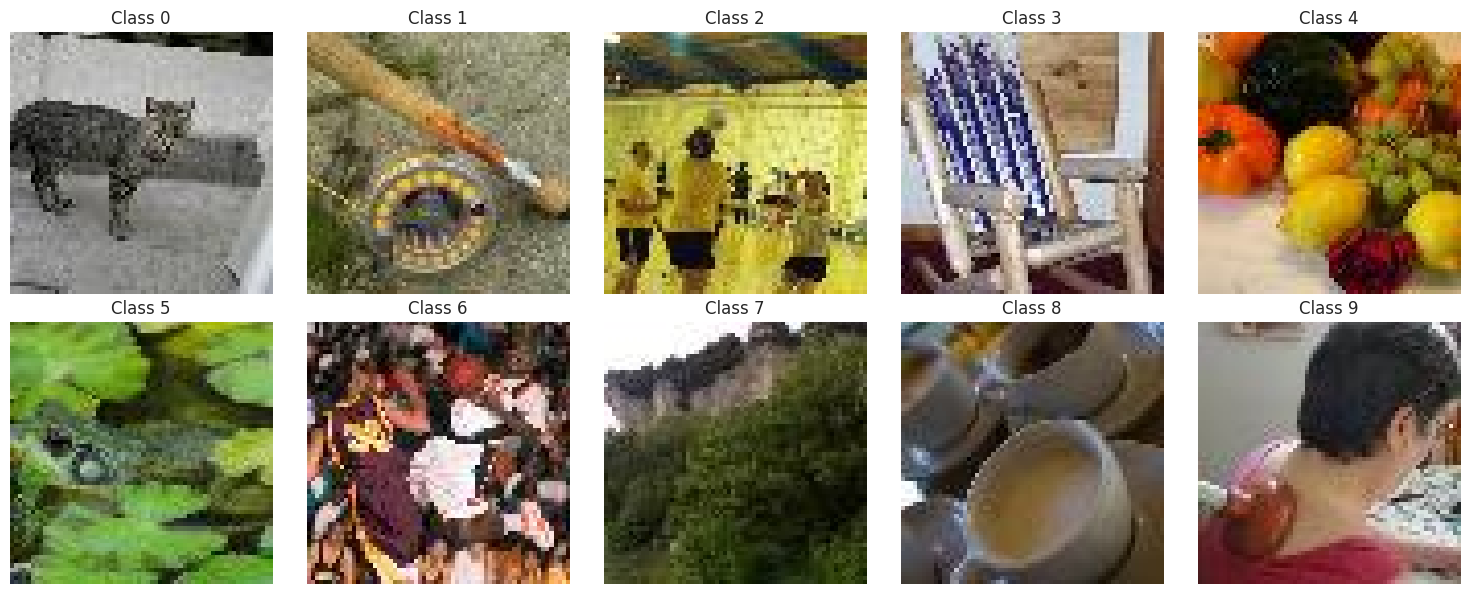

In [ ]:
# Load TinyImageNet dataset
from scenarios.datasets.load_imagenet import load_imagenet
from scenarios.utils import filter_classes

print("Loading TinyImageNet dataset...")
train_imagenet_full, test_imagenet_full = load_imagenet(balanced=False, number_of_samples_per_class=None)

# Filter to first 10 classes (as used in the scenarios)
train_imagenet, test_imagenet = filter_classes(train_imagenet_full, test_imagenet_full, 
                                              classes=list(range(10)))

print(f"TinyImageNet Train size (filtered): {len(train_imagenet)}")
print(f"TinyImageNet Test size (filtered): {len(test_imagenet)}")
print(f"TinyImageNet Full Train size: {len(train_imagenet_full)}")
print(f"TinyImageNet Full Test size: {len(test_imagenet_full)}")

print("Note: TinyImageNet is a subset of ImageNet with 200 classes")
print("We're using first 10 classes for continual learning scenario")

# Analyze filtered train set
imagenet_stats = analyze_dataset(train_imagenet, "TinyImageNet Train (filtered)", num_examples_per_class=3)


DATASET COMPARISON
      Dataset  Size  Classes                   Shape  Min samples/class  Max samples/class  Avg samples/class
        MNIST 60000       10 torch.Size([3, 64, 64])               5421               6742             6000.0
Fashion-MNIST 60000       10 torch.Size([3, 64, 64])               6000               6000             6000.0
         SVHN 73257       10 torch.Size([3, 64, 64])               4659              13861             7325.7
     CIFAR-10 50000       10 torch.Size([3, 64, 64])               5000               5000             5000.0
     Omniglot   160       10 torch.Size([3, 64, 64])                 11                 20               16.0
 TinyImageNet  5000       10 torch.Size([3, 64, 64])                500                500              500.0


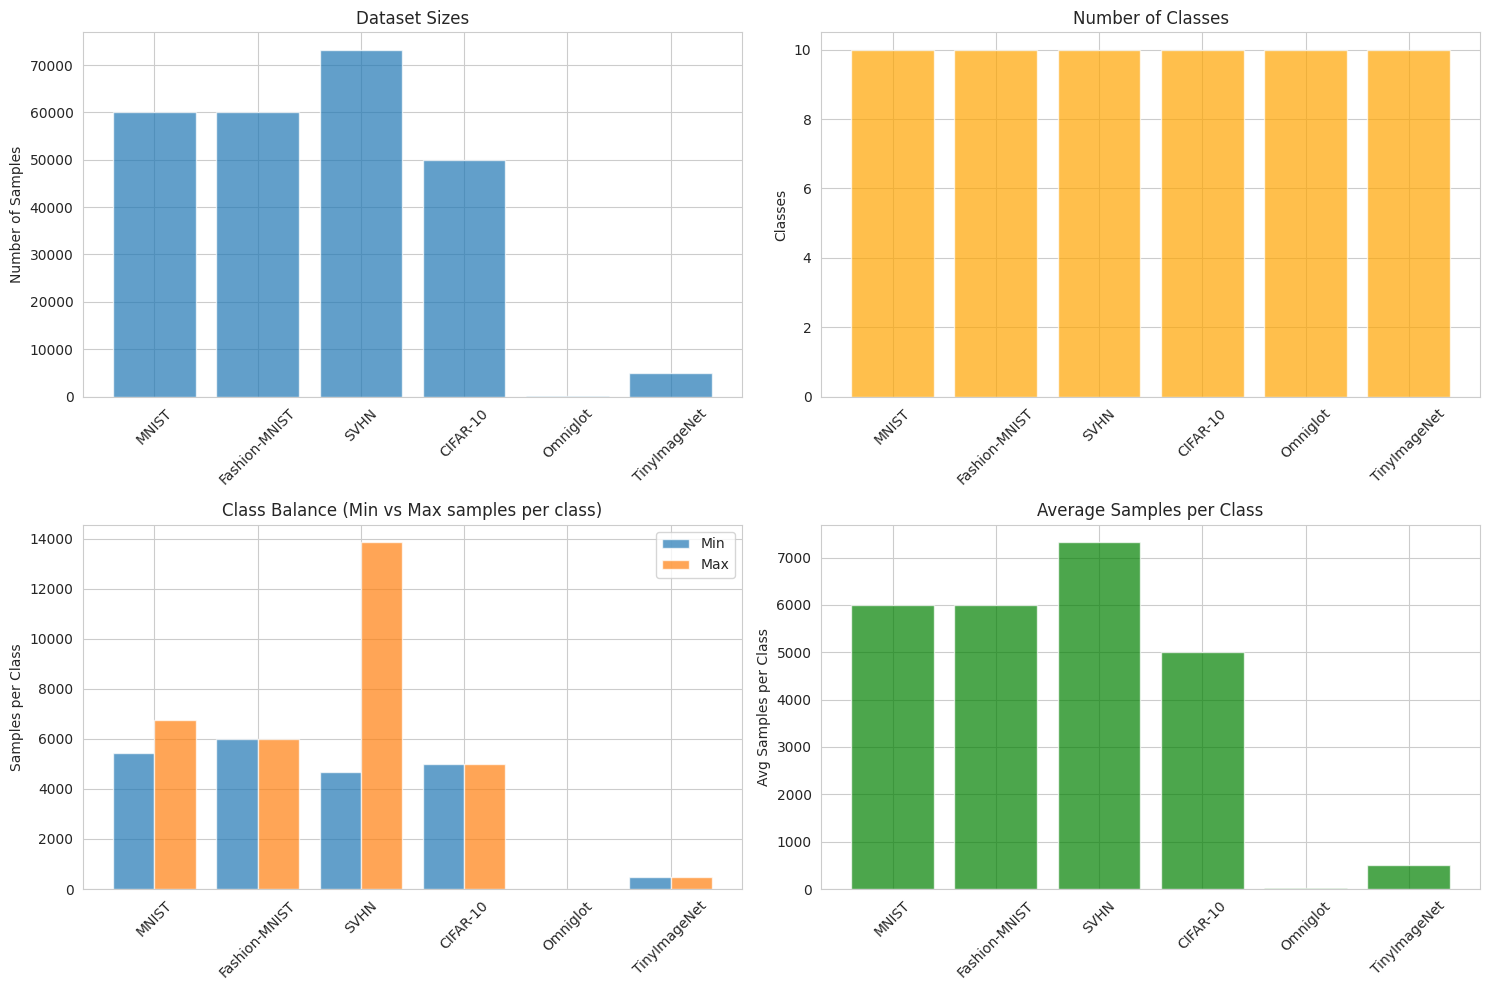

In [ ]:
# Collect all dataset statistics
all_dataset_stats = {
    'MNIST': mnist_stats,
    'Fashion-MNIST': fashion_stats,
    'SVHN': svhn_stats,
    'CIFAR-10': cifar_stats,
    'Omniglot': omniglot_stats,
    'TinyImageNet': imagenet_stats
}

# Compare all datasets
compare_datasets(all_dataset_stats)

In [ ]:
# Test the actual scenarios used in the paper
from scenarios.scenarios_providers import (
    get_short_mnist_omniglot_fmnist_svhn_cifar10_imagenet,
    get_short_imagenet_cifar10_svhn_fmnist_omniglot_mnist
)

print("Testing Continual Learning Scenarios...")

# Scenario 1: MNIST to ImageNet
print("\n" + "="*50)
print("SCENARIO 1: MNIST → Omniglot → Fashion-MNIST → SVHN → CIFAR-10 → ImageNet")
print("="*50)

scenario1_class_inc = get_short_mnist_omniglot_fmnist_svhn_cifar10_imagenet(
    class_incremental=True, balanced=True, number_of_samples_per_class=500
)

print("Class Incremental Learning:")
for i, train_exp in enumerate(scenario1_class_inc.train_stream):
    print(f"Experience {i}: {len(train_exp.dataset)} samples")
    if hasattr(train_exp.dataset, 'targets'):
        unique_classes = np.unique(train_exp.dataset.targets)
        print(f"  Classes: {list(unique_classes)} (range: {min(unique_classes)}-{max(unique_classes)})")

scenario1_task_inc = get_short_mnist_omniglot_fmnist_svhn_cifar10_imagenet(
    class_incremental=False, balanced=True, number_of_samples_per_class=500
)

print("\nTask Incremental Learning:")
for i, train_exp in enumerate(scenario1_task_inc.train_stream):
    print(f"Experience {i}: {len(train_exp.dataset)} samples")
    if hasattr(train_exp.dataset, 'targets'):
        unique_classes = np.unique(train_exp.dataset.targets)
        print(f"  Classes: {list(unique_classes)} (range: {min(unique_classes)}-{max(unique_classes)})")

# Scenario 2: ImageNet to MNIST  
print("\n" + "="*50)
print("SCENARIO 2: ImageNet → CIFAR-10 → SVHN → Fashion-MNIST → Omniglot → MNIST")
print("="*50)

scenario2_class_inc = get_short_imagenet_cifar10_svhn_fmnist_omniglot_mnist(
    class_incremental=True, balanced=True, number_of_samples_per_class=500
)

print("Class Incremental Learning:")
for i, train_exp in enumerate(scenario2_class_inc.train_stream):
    print(f"Experience {i}: {len(train_exp.dataset)} samples")
    if hasattr(train_exp.dataset, 'targets'):
        unique_classes = np.unique(train_exp.dataset.targets)
        print(f"  Classes: {list(unique_classes)} (range: {min(unique_classes)}-{max(unique_classes)})")

Testing Continual Learning Scenarios...

SCENARIO 1: MNIST → Omniglot → Fashion-MNIST → SVHN → CIFAR-10 → ImageNet
Files already downloaded and verified
Using downloaded and verified file: /home/brothen/M2I_I2M_benchmark/data/train_32x32.mat
Using downloaded and verified file: /home/brothen/M2I_I2M_benchmark/data/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


IndexError: list index out of range

In [ ]:
# Test the actual scenarios used in the paper
from scenarios.scenarios_providers import (
    get_short_mnist_omniglot_fmnist_svhn_cifar10_imagenet,
    get_short_imagenet_cifar10_svhn_fmnist_omniglot_mnist
)

print("Testing Continual Learning Scenarios...")

# Scenario 1: MNIST to ImageNet
print("\n" + "="*50)
print("SCENARIO 1: MNIST → Omniglot → Fashion-MNIST → SVHN → CIFAR-10 → ImageNet")
print("="*50)

scenario1_class_inc = get_short_mnist_omniglot_fmnist_svhn_cifar10_imagenet(
    class_incremental=True, balanced=True, number_of_samples_per_class=500
)

print("Class Incremental Learning:")
for i, train_exp in enumerate(scenario1_class_inc.train_stream):
    print(f"Experience {i}: {len(train_exp.dataset)} samples")
    if hasattr(train_exp.dataset, 'targets'):
        unique_classes = np.unique(train_exp.dataset.targets)
        print(f"  Classes: {list(unique_classes)} (range: {min(unique_classes)}-{max(unique_classes)})")

scenario1_task_inc = get_short_mnist_omniglot_fmnist_svhn_cifar10_imagenet(
    class_incremental=False, balanced=True, number_of_samples_per_class=500
)

print("\nTask Incremental Learning:")
for i, train_exp in enumerate(scenario1_task_inc.train_stream):
    print(f"Experience {i}: {len(train_exp.dataset)} samples")
    if hasattr(train_exp.dataset, 'targets'):
        unique_classes = np.unique(train_exp.dataset.targets)
        print(f"  Classes: {list(unique_classes)} (range: {min(unique_classes)}-{max(unique_classes)})")

# Scenario 2: ImageNet to MNIST  
print("\n" + "="*50)
print("SCENARIO 2: ImageNet → CIFAR-10 → SVHN → Fashion-MNIST → Omniglot → MNIST")
print("="*50)

scenario2_class_inc = get_short_imagenet_cifar10_svhn_fmnist_omniglot_mnist(
    class_incremental=True, balanced=True, number_of_samples_per_class=500
)

print("Class Incremental Learning:")
for i, train_exp in enumerate(scenario2_class_inc.train_stream):
    print(f"Experience {i}: {len(train_exp.dataset)} samples")
    if hasattr(train_exp.dataset, 'targets'):
        unique_classes = np.unique(train_exp.dataset.targets)
        print(f"  Classes: {list(unique_classes)} (range: {min(unique_classes)}-{max(unique_classes)})")

Testing Continual Learning Scenarios...

SCENARIO 1: MNIST → Omniglot → Fashion-MNIST → SVHN → CIFAR-10 → ImageNet
Files already downloaded and verified
Using downloaded and verified file: /home/brothen/M2I_I2M_benchmark/data/train_32x32.mat
Using downloaded and verified file: /home/brothen/M2I_I2M_benchmark/data/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


IndexError: list index out of range

Comparing Balanced vs Unbalanced Datasets...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


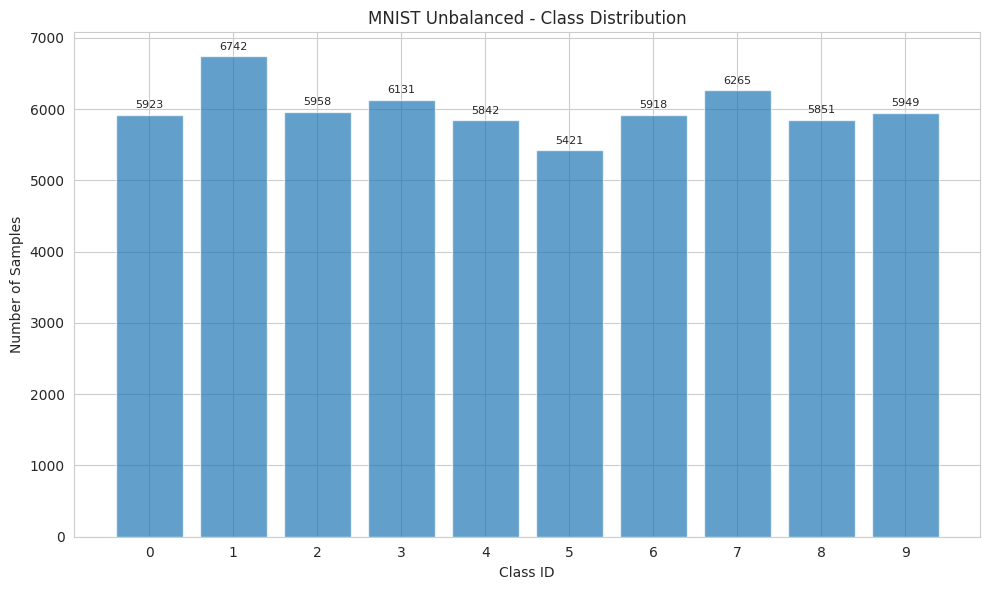

MNIST Unbalanced:
  Total samples: 60000
  Classes: 10
  Min samples per class: 5421
  Max samples per class: 6742
  Avg samples per class: 6000.0



ValueError: not enough values to unpack (expected 3, got 2)

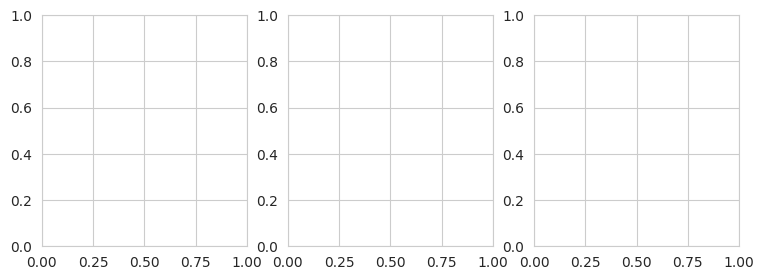

In [ ]:
# Compare balanced vs unbalanced datasets
print("Comparing Balanced vs Unbalanced Datasets...")

# Load balanced dataset (500 samples per class)
train_mnist_balanced, _ = load_mnist_with_resize(balanced=True, number_of_samples_per_class=500)
train_cifar_balanced, _ = load_resized_cifar10(balanced=True, number_of_samples_per_class=500)

# Load unbalanced dataset (all samples)
train_mnist_unbalanced, _ = load_mnist_with_resize(balanced=False, number_of_samples_per_class=None)
train_cifar_unbalanced, _ = load_resized_cifar10(balanced=False, number_of_samples_per_class=None)

# Analyze class distributions
def plot_class_distribution(dataset, title):
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
    else:
        targets = [dataset[i][1] for i in range(len(dataset))]
    
    if torch.is_tensor(targets):
        targets = targets.numpy()
    
    class_counts = Counter(targets)
    classes, counts = zip(*sorted(class_counts.items()))
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, alpha=0.7)
    plt.title(f'{title} - Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Samples')
    plt.xticks(classes)
    
    # Add count labels on bars
    for i, count in enumerate(counts):
        plt.text(classes[i], count + max(counts)*0.01, str(count), 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"{title}:")
    print(f"  Total samples: {len(dataset)}")
    print(f"  Classes: {len(classes)}")
    print(f"  Min samples per class: {min(counts)}")
    print(f"  Max samples per class: {max(counts)}")
    print(f"  Avg samples per class: {np.mean(counts):.1f}")
    print()

# Analyze class distributions
def plot_class_distribution(dataset, title):
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
    else:
        targets = [dataset[i][1] for i in range(len(dataset))]
    
    if torch.is_tensor(targets):
        targets = targets.numpy()
    
    class_counts = Counter(targets)
    classes, counts = zip(*sorted(class_counts.items()))
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, alpha=0.7)
    plt.title(f'{title} - Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Samples')
    plt.xticks(classes)
    
    # Add count labels on bars
    for i, count in enumerate(counts):
        plt.text(classes[i], count + max(counts)*0.01, str(count), 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"{title}:")
    print(f"  Total samples: {len(dataset)}")
    print(f"  Classes: {len(classes)}")
    print(f"  Min samples per class: {min(counts)}")
    print(f"  Max samples per class: {max(counts)}")
    print(f"  Avg samples per class: {np.mean(counts):.1f}")
    print()

# Show a few sample images from each dataset for visual verification
def show_sample_images(dataset, title, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(3*num_samples, 3))
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        img, label, _ = dataset[i * len(dataset) // num_samples]
        
        # Use smart display instead of denormalization
        img_display, display_method = smart_display_image(img)
        
        if len(img_display.shape) == 2 or (len(img_display.shape) == 3 and img_display.shape[2] == 1):
            axes[i].imshow(img_display.squeeze(), cmap='gray', vmin=0, vmax=1)
        else:
            axes[i].imshow(img_display)
        
        axes[i].set_title(f'Sample {i+1}\nClass {label}')
        axes[i].axis('off')
    
    plt.suptitle(f'{title} - Sample Images (Method: {display_method})')
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_mnist_unbalanced, "MNIST Unbalanced")
show_sample_images(train_mnist_unbalanced, "MNIST", num_samples=3)

plot_class_distribution(train_mnist_balanced, "MNIST Balanced (500/class)")
show_sample_images(train_mnist_balanced, "MNIST", num_samples=3)

plot_class_distribution(train_cifar_unbalanced, "CIFAR-10 Unbalanced")
show_sample_images(train_cifar_unbalanced, "CIFAR-10", num_samples=3)

plot_class_distribution(train_cifar_balanced, "CIFAR-10 Balanced (500/class)")
show_sample_images(train_cifar_balanced, "CIFAR-10", num_samples=3)

In [ ]:
# Compare balanced vs unbalanced datasets
print("Comparing Balanced vs Unbalanced Datasets...")

# Load balanced dataset (500 samples per class)
train_mnist_balanced, _ = load_mnist_with_resize(balanced=True, number_of_samples_per_class=500)
train_cifar_balanced, _ = load_resized_cifar10(balanced=True, number_of_samples_per_class=500)

# Load unbalanced dataset (all samples)
train_mnist_unbalanced, _ = load_mnist_with_resize(balanced=False, number_of_samples_per_class=None)
train_cifar_unbalanced, _ = load_resized_cifar10(balanced=False, number_of_samples_per_class=None)

# Analyze class distributions
def plot_class_distribution(dataset, title):
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
    else:
        targets = [dataset[i][1] for i in range(len(dataset))]
    
    if torch.is_tensor(targets):
        targets = targets.numpy()
    
    class_counts = Counter(targets)
    classes, counts = zip(*sorted(class_counts.items()))
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, alpha=0.7)
    plt.title(f'{title} - Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Samples')
    plt.xticks(classes)
    
    # Add count labels on bars
    for i, count in enumerate(counts):
        plt.text(classes[i], count + max(counts)*0.01, str(count), 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"{title}:")
    print(f"  Total samples: {len(dataset)}")
    print(f"  Classes: {len(classes)}")
    print(f"  Min samples per class: {min(counts)}")
    print(f"  Max samples per class: {max(counts)}")
    print(f"  Avg samples per class: {np.mean(counts):.1f}")
    print()

# Analyze class distributions
def plot_class_distribution(dataset, title):
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
    else:
        targets = [dataset[i][1] for i in range(len(dataset))]
    
    if torch.is_tensor(targets):
        targets = targets.numpy()
    
    class_counts = Counter(targets)
    classes, counts = zip(*sorted(class_counts.items()))
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, alpha=0.7)
    plt.title(f'{title} - Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Samples')
    plt.xticks(classes)
    
    # Add count labels on bars
    for i, count in enumerate(counts):
        plt.text(classes[i], count + max(counts)*0.01, str(count), 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"{title}:")
    print(f"  Total samples: {len(dataset)}")
    print(f"  Classes: {len(classes)}")
    print(f"  Min samples per class: {min(counts)}")
    print(f"  Max samples per class: {max(counts)}")
    print(f"  Avg samples per class: {np.mean(counts):.1f}")
    print()

# Show a few sample images from each dataset for visual verification
def show_sample_images(dataset, title, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(3*num_samples, 3))
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        img, label = dataset[i * len(dataset) // num_samples]
        
        # Use smart display instead of denormalization
        img_display, display_method = smart_display_image(img)
        
        if len(img_display.shape) == 2 or (len(img_display.shape) == 3 and img_display.shape[2] == 1):
            axes[i].imshow(img_display.squeeze(), cmap='gray', vmin=0, vmax=1)
        else:
            axes[i].imshow(img_display)
        
        axes[i].set_title(f'Sample {i+1}\nClass {label}')
        axes[i].axis('off')
    
    plt.suptitle(f'{title} - Sample Images (Method: {display_method})')
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_mnist_unbalanced, "MNIST Unbalanced")
show_sample_images(train_mnist_unbalanced, "MNIST", num_samples=3)

plot_class_distribution(train_mnist_balanced, "MNIST Balanced (500/class)")
show_sample_images(train_mnist_balanced, "MNIST", num_samples=3)

plot_class_distribution(train_cifar_unbalanced, "CIFAR-10 Unbalanced")
show_sample_images(train_cifar_unbalanced, "CIFAR-10", num_samples=3)

plot_class_distribution(train_cifar_balanced, "CIFAR-10 Balanced (500/class)")
show_sample_images(train_cifar_balanced, "CIFAR-10", num_samples=3)

Comparing Balanced vs Unbalanced Datasets...


TypeError: unhashable type: 'Image'

Comparing Balanced vs Unbalanced Datasets...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


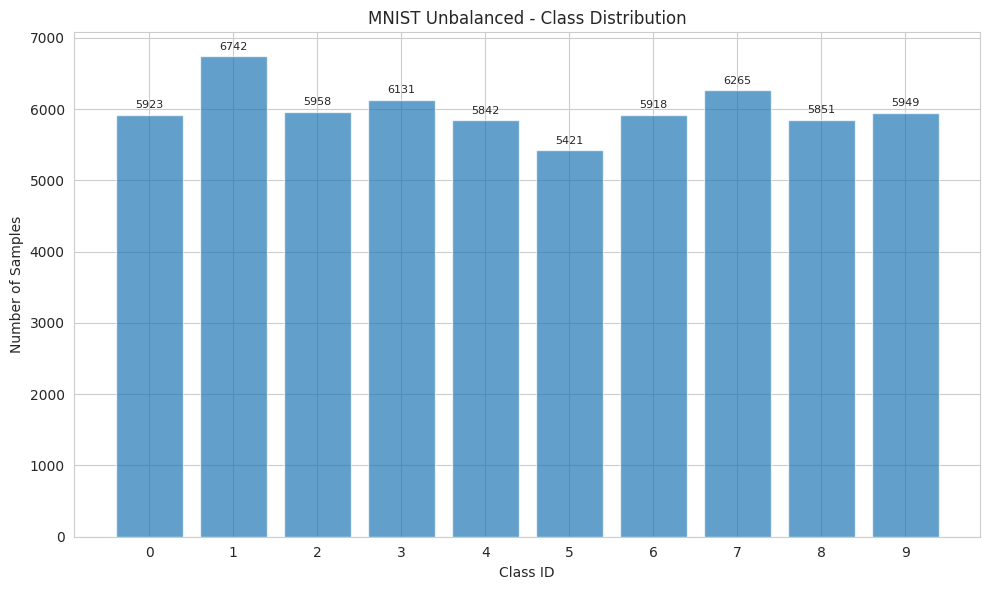

MNIST Unbalanced:
  Total samples: 60000
  Classes: 10
  Min samples per class: 5421
  Max samples per class: 6742
  Avg samples per class: 6000.0



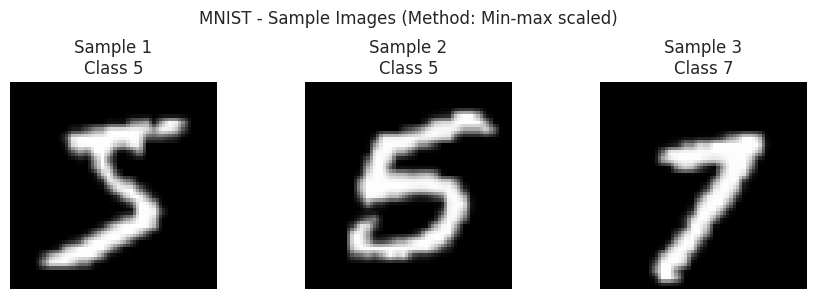

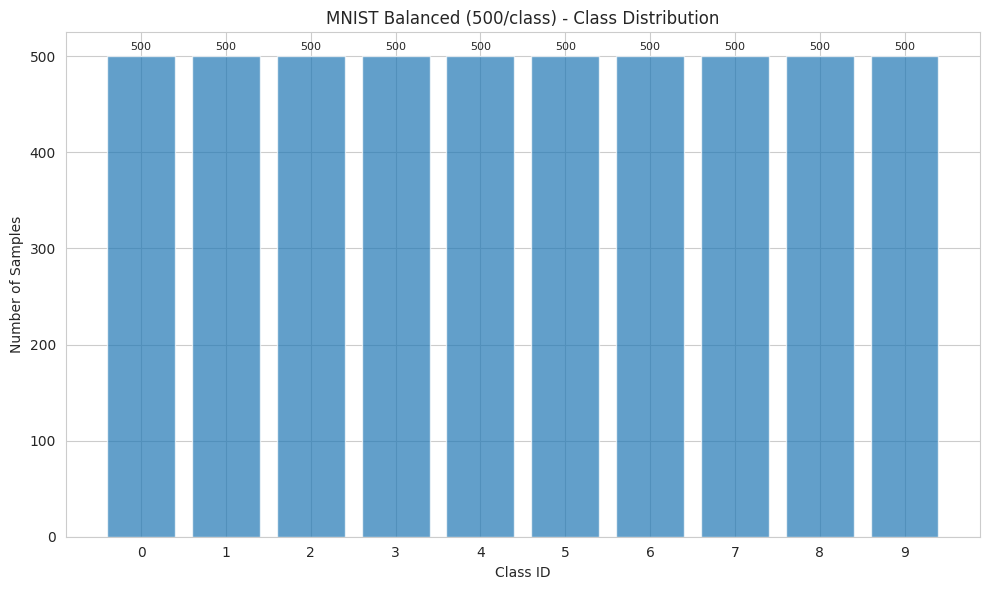

MNIST Balanced (500/class):
  Total samples: 5000
  Classes: 10
  Min samples per class: 500
  Max samples per class: 500
  Avg samples per class: 500.0



ValueError: too many values to unpack (expected 2)

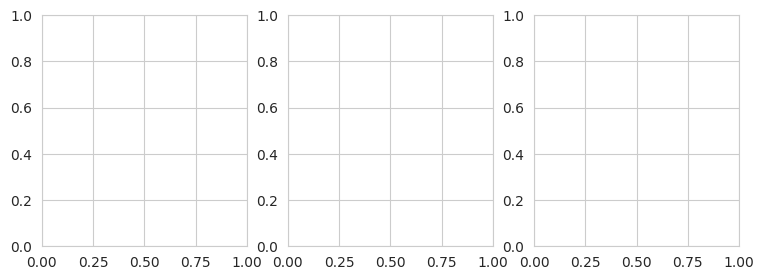

In [ ]:
# Compare balanced vs unbalanced datasets
print("Comparing Balanced vs Unbalanced Datasets...")

# Load balanced dataset (500 samples per class)
train_mnist_balanced, _ = load_mnist_with_resize(balanced=True, number_of_samples_per_class=500)
train_cifar_balanced, _ = load_resized_cifar10(balanced=True, number_of_samples_per_class=500)

# Load unbalanced dataset (all samples)
train_mnist_unbalanced, _ = load_mnist_with_resize(balanced=False, number_of_samples_per_class=None)
train_cifar_unbalanced, _ = load_resized_cifar10(balanced=False, number_of_samples_per_class=None)

# Analyze class distributions
def plot_class_distribution(dataset, title):
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
    else:
        targets = [dataset[i][1] for i in range(len(dataset))]
    
    if torch.is_tensor(targets):
        targets = targets.numpy()
    
    class_counts = Counter(targets)
    classes, counts = zip(*sorted(class_counts.items()))
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, alpha=0.7)
    plt.title(f'{title} - Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Samples')
    plt.xticks(classes)
    
    # Add count labels on bars
    for i, count in enumerate(counts):
        plt.text(classes[i], count + max(counts)*0.01, str(count), 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"{title}:")
    print(f"  Total samples: {len(dataset)}")
    print(f"  Classes: {len(classes)}")
    print(f"  Min samples per class: {min(counts)}")
    print(f"  Max samples per class: {max(counts)}")
    print(f"  Avg samples per class: {np.mean(counts):.1f}")
    print()

# Analyze class distributions
def plot_class_distribution(dataset, title):
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
    else:
        targets = [dataset[i][1] for i in range(len(dataset))]
    
    if torch.is_tensor(targets):
        targets = targets.numpy()
    
    class_counts = Counter(targets)
    classes, counts = zip(*sorted(class_counts.items()))
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, alpha=0.7)
    plt.title(f'{title} - Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Number of Samples')
    plt.xticks(classes)
    
    # Add count labels on bars
    for i, count in enumerate(counts):
        plt.text(classes[i], count + max(counts)*0.01, str(count), 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"{title}:")
    print(f"  Total samples: {len(dataset)}")
    print(f"  Classes: {len(classes)}")
    print(f"  Min samples per class: {min(counts)}")
    print(f"  Max samples per class: {max(counts)}")
    print(f"  Avg samples per class: {np.mean(counts):.1f}")
    print()

# Show a few sample images from each dataset for visual verification
def show_sample_images(dataset, title, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(3*num_samples, 3))
    axes = axes if num_samples > 1 else [axes]

    ds_len = len(dataset)
    for i in range(num_samples):
        sample = dataset[i * ds_len // num_samples]
        img, label = sample[:2]          # ← works for 2- or 3-item tuples

        img_disp, method = smart_display_image(img)

        axes[i].imshow(img_disp.squeeze() if img_disp.ndim == 2 
                       else img_disp)
        axes[i].set_title(f'Sample {i+1}\nClass {label}')
        axes[i].axis('off')

    plt.suptitle(f'{title} – Sample Images (Method: {method})')
    plt.tight_layout()
    plt.show()


plot_class_distribution(train_mnist_unbalanced, "MNIST Unbalanced")
show_sample_images(train_mnist_unbalanced, "MNIST", num_samples=3)

plot_class_distribution(train_mnist_balanced, "MNIST Balanced (500/class)")
show_sample_images(train_mnist_balanced, "MNIST", num_samples=3)

plot_class_distribution(train_cifar_unbalanced, "CIFAR-10 Unbalanced")
show_sample_images(train_cifar_unbalanced, "CIFAR-10", num_samples=3)

plot_class_distribution(train_cifar_balanced, "CIFAR-10 Balanced (500/class)")
show_sample_images(train_cifar_balanced, "CIFAR-10", num_samples=3)